In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import warnings
import gc
warnings.filterwarnings('ignore')

from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from torchvision import transforms
from tqdm import tqdm
import joblib
from PIL import Image
from collections import OrderedDict

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
np.random.seed(42)
torch.manual_seed(42)


def get_device():
    """Get the best available device."""
    if torch.cuda.is_available():
        return torch.device('cuda')
    elif torch.backends.mps.is_available():
        return torch.device('mps')
    return torch.device('cpu')

DEVICE = get_device()
print(f"Using device: {DEVICE}")

print("Libraries loaded successfully")

torch.set_default_dtype(torch.float32)
torch.backends.cuda.matmul.allow_tf32 = False
torch.backends.cudnn.allow_tf32 = False

Using device: mps
Libraries loaded successfully


In [2]:
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['NUMEXPR_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'

In [3]:
import gc
import torch

def clear_memory():
    """Aggressively clear memory - call after heavy operations"""
    gc.collect()
    if torch.backends.mps.is_available():
        torch.mps.empty_cache()
    elif torch.cuda.is_available():
        torch.cuda.empty_cache()
    print("Memory cleared")


## 1. Configuration and Data Loading

In [19]:
class Config:
    """Configuration class for paths and hyperparameters"""
    
    # Data paths - UPDATE THESE
    TRAINING_DATA_PATH = '../data/processed/train.csv'
    VALIDATION_DATA_PATH = '../data/processed/val.csv'
    IMAGE_DIRECTORY = '../data/satellite_images_19'

    # Output paths
    OUTPUT_DIR = 'outputs'
    MODEL_DIR = 'saved_models'
    RESULTS_DIR = 'experiment_results'
    
    # Image settings
    IMG_SIZE = 224
    IMG_CHANNELS = 3
    
    # Training settings
    FEATURE_EXTRACTION_BATCH_SIZE = 8
    BATCH_SIZE = 32
    NUM_WORKERS = 0
    NUM_EPOCHS = 15
    EARLY_STOP_PATIENCE = 8
    
    # Available CNN backbones
    AVAILABLE_BACKBONES = ['resnet50', 'resnet101', 'inception_v3', 'efficientnet_b0', 'densenet121']
    
    # Random seed
    SEED = 42

cfg = Config()

# Create output directories
for directory in [cfg.OUTPUT_DIR, cfg.MODEL_DIR, cfg.RESULTS_DIR]:
    os.makedirs(directory, exist_ok=True)

In [5]:
# Load preprocessed data
training_data = pd.read_csv(cfg.TRAINING_DATA_PATH)
validation_data = pd.read_csv(cfg.VALIDATION_DATA_PATH)

print(f"Training samples: {training_data.shape}")
print(f"Validation samples: {validation_data.shape}")
print(f"\nTraining columns: {list(training_data.columns[:10])}...")

Training samples: (12967, 48)
Validation samples: (3242, 48)

Training columns: ['bedrooms', 'bathrooms', 'sqft_living', 'waterfront', 'view', 'grade', 'sqft_above', 'sqft_living15', 'sqft_lot15', 'age']...


In [6]:
# Identify feature columns (exclude target, image_path)
exclude_cols = ['price', 'image_path']
feature_columns = [col for col in training_data.columns if col not in exclude_cols]

print(f"Number of features: {len(feature_columns)}")
print(f"Features: {feature_columns[:10]}...")

Number of features: 46
Features: ['bedrooms', 'bathrooms', 'sqft_living', 'waterfront', 'view', 'grade', 'sqft_above', 'sqft_living15', 'sqft_lot15', 'age']...


## 2. Target Variable Transformation

In [7]:
def apply_log_transformation(df, target_col='price'):
    """Apply log1p transformation to target variable"""
    df = df.copy()
    df['price_log'] = np.log1p(df[target_col])
    return df

def compute_normalization_params(train_df, col='price_log'):
    """Compute mean and std from training data"""
    mean_val = train_df[col].mean()
    std_val = train_df[col].std()
    return mean_val, std_val

def normalize_target(df, mean_val, std_val, col='price_log'):
    """Z-score normalize the target"""
    df = df.copy()
    df['price_normalized'] = (df[col] - mean_val) / std_val
    return df

def inverse_transform_predictions(normalized_preds, mean_val, std_val):
    """Convert normalized predictions back to original scale"""
    log_prices = normalized_preds * std_val + mean_val
    original_prices = np.expm1(log_prices)
    return original_prices

In [8]:
# Apply transformations
print("=" * 70)
print("TARGET VARIABLE TRANSFORMATION")
print("=" * 70)

training_data = apply_log_transformation(training_data)
validation_data = apply_log_transformation(validation_data)

target_mean, target_std = compute_normalization_params(training_data)

training_data = normalize_target(training_data, target_mean, target_std)
validation_data = normalize_target(validation_data, target_mean, target_std)

print(f"\nOriginal price range:")
print(f"  Training: ${training_data['price'].min():,.0f} - ${training_data['price'].max():,.0f}")
print(f"  Validation: ${validation_data['price'].min():,.0f} - ${validation_data['price'].max():,.0f}")

print(f"\nNormalized price range:")
print(f"  Training: {training_data['price_normalized'].min():.3f} - {training_data['price_normalized'].max():.3f}")
print(f"  Validation: {validation_data['price_normalized'].min():.3f} - {validation_data['price_normalized'].max():.3f}")

print(f"\nNormalization parameters:")
print(f"  Mean (log scale): {target_mean:.4f}")
print(f"  Std (log scale): {target_std:.4f}")

# Save normalization params
np.save(os.path.join(cfg.OUTPUT_DIR, 'target_mean.npy'), target_mean)
np.save(os.path.join(cfg.OUTPUT_DIR, 'target_std.npy'), target_std)

TARGET VARIABLE TRANSFORMATION

Original price range:
  Training: $80,000 - $7,700,000
  Validation: $75,000 - $5,110,800

Normalized price range:
  Training: -3.351 - 5.373
  Validation: -3.474 - 4.590

Normalization parameters:
  Mean (log scale): 13.0440
  Std (log scale): 0.5235


In [9]:
# Prepare feature matrices
X_train_tabular = training_data[feature_columns].values
y_train_original = training_data['price'].values
y_train_normalized = training_data['price_normalized'].values

X_val_tabular = validation_data[feature_columns].values
y_val_original = validation_data['price'].values
y_val_normalized = validation_data['price_normalized'].values

print(f"\nFeature matrices:")
print(f"  X_train: {X_train_tabular.shape}")
print(f"  X_val: {X_val_tabular.shape}")


Feature matrices:
  X_train: (12967, 46)
  X_val: (3242, 46)


## 3. CNN Feature Extraction

In [87]:
class BackboneFactory:
    """Factory class to create different CNN backbones"""
    
    @staticmethod
    def get_backbone(backbone_name, pretrained=True):
        """
        Returns backbone model, output feature dimension, and target layer for GradCAM
        """
        backbone_name = backbone_name.lower()
        
        if backbone_name == 'resnet50':
            model = models.resnet50(pretrained=pretrained)
            feature_extractor = nn.Sequential(*list(model.children())[:-1])
            output_dim = 2048
            gradcam_layer = 'layer4'
            
        elif backbone_name == 'resnet101':
            model = models.resnet101(pretrained=pretrained)
            feature_extractor = nn.Sequential(*list(model.children())[:-1])
            output_dim = 2048
            gradcam_layer = 'layer4'
            
        elif backbone_name == 'inception_v3':
            model = models.inception_v3(pretrained=pretrained, aux_logits=True)
            feature_extractor = nn.Sequential(
                model.Conv2d_1a_3x3,
                model.Conv2d_2a_3x3,
                model.Conv2d_2b_3x3,
                nn.MaxPool2d(kernel_size=3, stride=2),
                model.Conv2d_3b_1x1,
                model.Conv2d_4a_3x3,
                nn.MaxPool2d(kernel_size=3, stride=2),
                model.Mixed_5b,
                model.Mixed_5c,
                model.Mixed_5d,
                model.Mixed_6a,
                model.Mixed_6b,
                model.Mixed_6c,
                model.Mixed_6d,
                model.Mixed_6e,
                model.Mixed_7a,
                model.Mixed_7b,
                model.Mixed_7c,
                nn.AdaptiveAvgPool2d((1, 1))
            )
            output_dim = 2048
            gradcam_layer = 'Mixed_7c'
            
        elif backbone_name == 'efficientnet_b0':
            model = models.efficientnet_b0(pretrained=pretrained)
            feature_extractor = nn.Sequential(
                model.features,
                nn.AdaptiveAvgPool2d((1, 1))
            )
            output_dim = 1280
            gradcam_layer = 'features'
            
        elif backbone_name == 'densenet121':
            model = models.densenet121(pretrained=pretrained)
            feature_extractor = nn.Sequential(
                model.features,
                nn.ReLU(inplace=True),
                nn.AdaptiveAvgPool2d((1, 1))
            )
            output_dim = 1024
            gradcam_layer = 'features'
            
        else:
            raise ValueError(f"Unknown backbone: {backbone_name}. Available: {cfg.AVAILABLE_BACKBONES}")
        
        return feature_extractor, output_dim, gradcam_layer

In [88]:
BACKBONE_STAGE_MAP = {
    "resnet50": {
        "layer3": 6,
        "layer4": 7
    },
    "resnet101": {
        "layer3": 6,
        "layer4": 7
    },
    "efficientnet_b0": {
        "features": 0   # model.features
    },
    "densenet121": {
        "features": 0
    },
    "inception_v3": {
        "Mixed_7c": -2
    }
}


In [11]:
class ImageFeatureExtractor(nn.Module):
    """Extract features from images using specified backbone"""
    
    def __init__(self, backbone_name='resnet50'):
        super(ImageFeatureExtractor, self).__init__()
        
        self.backbone_name = backbone_name
        self.feature_extractor, self.output_dim, self.gradcam_layer = BackboneFactory.get_backbone(backbone_name)
        
        # Freeze backbone weights
        for param in self.feature_extractor.parameters():
            param.requires_grad = False
    
    def forward(self, x):
        features = self.feature_extractor(x)
        features = torch.flatten(features, 1)
        return features

In [20]:
class ImageDataset(Dataset):
    """Dataset for image feature extraction"""

    def __init__(self, dataframe, image_dir, image_col="image_path", transform=None):
        self.dataframe = dataframe.reset_index(drop=False)  
        # keep original index in a column called "index"
        self.image_dir = image_dir
        self.image_col = image_col
        self.transform = transform

        self.valid_indices = []

        for idx in range(len(self.dataframe)):
            img_path = os.path.join(
                self.image_dir,
                str(self.dataframe.loc[idx, self.image_col])
            )
            if os.path.exists(img_path):
                self.valid_indices.append(idx)

        print(f"Valid samples: {len(self.valid_indices)}/{len(self.dataframe)}")

    def __len__(self):
        return len(self.valid_indices)

    def __getitem__(self, idx):
        actual_idx = self.valid_indices[idx]

        img_name = self.dataframe.loc[actual_idx, self.image_col]
        img_path = os.path.join(self.image_dir, str(img_name))

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (cfg.IMG_SIZE, cfg.IMG_SIZE))

        if self.transform:
            image = self.transform(image)

        return {
            "image": image,
            "sample_id": int(self.dataframe.loc[actual_idx, "index"])
        }


In [13]:
# Compute image statistics from training set
def compute_image_statistics(
    dataframe,
    image_dir,
    image_col="image_path",
    sample_size=1000,
):
    """
    Compute mean and std of images for normalization
    (memory-safe streaming version)
    """

    sample_df = dataframe.sample(
        n=min(sample_size, len(dataframe)),
        random_state=cfg.SEED
    )

    channel_sum = np.zeros(3, dtype=np.float64)
    channel_sq_sum = np.zeros(3, dtype=np.float64)
    pixel_count = 0

    for _, row in tqdm(sample_df.iterrows(), total=len(sample_df), desc="Computing image stats"):
        img_path = os.path.join(image_dir, str(row[image_col]))

        if not os.path.exists(img_path):
            continue

        img = cv2.imread(img_path)
        if img is None:
            continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32) / 255.0

        h, w, c = img.shape
        pixel_count += h * w

        channel_sum += img.sum(axis=(0, 1))
        channel_sq_sum += (img ** 2).sum(axis=(0, 1))

    mean = channel_sum / pixel_count
    std = np.sqrt(channel_sq_sum / pixel_count - mean ** 2)

    return mean, std


In [14]:
print("Computing image normalization statistics...")
IMAGE_MEAN, IMAGE_STD = compute_image_statistics(training_data, cfg.IMAGE_DIRECTORY)
print(f"Image Mean: {IMAGE_MEAN}")
print(f"Image Std: {IMAGE_STD}")

np.save(os.path.join(cfg.OUTPUT_DIR, 'image_mean.npy'), IMAGE_MEAN)
np.save(os.path.join(cfg.OUTPUT_DIR, 'image_std.npy'), IMAGE_STD)

Computing image normalization statistics...


Computing image stats:   0%|          | 0/1000 [00:00<?, ?it/s]

Computing image stats: 100%|██████████| 1000/1000 [00:13<00:00, 74.29it/s]

Image Mean: [0.39838744 0.42641891 0.41923702]
Image Std: [0.23704267 0.20149684 0.18431577]


In [15]:
# Define image transforms
image_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGE_MEAN, std=IMAGE_STD)
])

image_transform_with_resize = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((cfg.IMG_SIZE, cfg.IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGE_MEAN, std=IMAGE_STD)
])

In [21]:
def extract_cnn_features(
    dataframe,
    image_dir,
    backbone_name="resnet50",
    batch_size=4,
    chunk_size=100,
):
    """
    Memory-efficient CNN feature extraction with chunking
    """

    extractor = ImageFeatureExtractor(
        backbone_name=backbone_name
    ).to(DEVICE)

    extractor.eval()
    output_dim = extractor.output_dim

    print(f"Extracting {backbone_name} features ({output_dim}-dim)")
    print(f"Chunk size: {chunk_size}")

    feature_dict = {}

    num_chunks = (len(dataframe) + chunk_size - 1) // chunk_size

    for chunk_idx in range(num_chunks):
        start = chunk_idx * chunk_size
        end = min((chunk_idx + 1) * chunk_size, len(dataframe))

        print(f"\nChunk {chunk_idx+1}/{num_chunks} [{start}:{end}]")

        chunk_df = dataframe.iloc[start:end]

        dataset = ImageDataset(
            chunk_df,
            image_dir,
            transform=image_transform
        )

        dataloader = DataLoader(
            dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=0,     # REQUIRED on macOS
            pin_memory=False
        )

        with torch.no_grad():
            for batch in tqdm(dataloader, desc="Extracting"):
                images = batch["image"].to(DEVICE)
                sample_ids = batch["sample_id"].tolist()

                feats = extractor(images)
                feats = feats.cpu().numpy()

                for i, sid in enumerate(sample_ids):
                    feature_dict[sid] = feats[i]

                del images, feats

        del dataset, dataloader, chunk_df
        clear_memory()

        print(f"Features collected: {len(feature_dict)}")

    return feature_dict, output_dim


In [22]:
clear_memory()

Memory cleared


In [ ]:
print("=" * 70)
print("CNN FEATURE EXTRACTION")
print("=" * 70)

# Extract features using ResNet50 (default backbone)
train_image_features, cnn_feature_dim = extract_cnn_features(
    training_data,
    cfg.IMAGE_DIRECTORY,
    backbone_name="resnet50",
    batch_size=4
)

val_image_features, _ = extract_cnn_features(
    validation_data,
    cfg.IMAGE_DIRECTORY,
    backbone_name="resnet50",
    batch_size=4
)

print(len(train_image_features), cnn_feature_dim)

In [26]:
def build_feature_matrix(dataframe, feature_dict, feature_dim):
    """
    Create aligned feature matrix using dataframe index as key
    """
    feature_matrix = np.zeros((len(dataframe), feature_dim), dtype=np.float32)

    for row_idx, df_idx in enumerate(dataframe.index):
        if df_idx in feature_dict:
            feature_matrix[row_idx] = feature_dict[df_idx]
        else:
            # Optional: warn or leave zeros if image missing
            pass

    return feature_matrix


In [27]:
# Build feature matrices
X_train_cnn = build_feature_matrix(training_data, train_image_features, cnn_feature_dim)
X_val_cnn = build_feature_matrix(validation_data, val_image_features, cnn_feature_dim)

# Combine tabular and CNN features
X_train_multimodal = np.hstack([X_train_tabular, X_train_cnn])
X_val_multimodal = np.hstack([X_val_tabular, X_val_cnn])

print(f"\nCombined feature matrices:")
print(f"  Training: {X_train_multimodal.shape}")
print(f"  Validation: {X_val_multimodal.shape}")
print(f"    - Tabular: {X_train_tabular.shape[1]}")
print(f"    - CNN: {X_train_cnn.shape[1]}")

# Save CNN features
np.save(os.path.join(cfg.OUTPUT_DIR, 'train_cnn_features.npy'), X_train_cnn)
np.save(os.path.join(cfg.OUTPUT_DIR, 'val_cnn_features.npy'), X_val_cnn)


Combined feature matrices:
  Training: (12967, 2094)
  Validation: (3242, 2094)
    - Tabular: 46
    - CNN: 2048


## 4. Utility Functions

In [29]:
def compute_regression_metrics(y_true, y_pred, dataset_label="Dataset"):
    """Calculate comprehensive regression metrics"""
    
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    mse = mean_squared_error(y_true, y_pred)
    
    return {
        'Dataset': dataset_label,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'MAPE': mape,
        'MSE': mse
    }

In [30]:
def train_evaluate_ml_model(model, X_tr, y_tr, X_va, y_va, model_label):
    """Train and evaluate machine learning model"""
    
    print(f"\nTraining {model_label}...")
    
    model.fit(X_tr, y_tr)
    
    y_tr_pred = model.predict(X_tr)
    train_metrics = compute_regression_metrics(y_tr, y_tr_pred, "Train")
    
    y_va_pred = model.predict(X_va)
    val_metrics = compute_regression_metrics(y_va, y_va_pred, "Validation")
    
    print(f"\n{model_label} Results:")
    print("-" * 65)
    print(f"{'Metric':<12} {'Train':<18} {'Validation':<18} {'Gap':<12}")
    print("-" * 65)
    
    for metric in ['RMSE', 'MAE', 'R2', 'MAPE']:
        tr_val = train_metrics[metric]
        va_val = val_metrics[metric]
        
        if metric == 'R2':
            gap = tr_val - va_val
            gap_str = f"{gap:+.4f}"
        else:
            gap = (va_val - tr_val) / tr_val * 100 if tr_val != 0 else 0
            gap_str = f"{gap:+.1f}%"
        
        print(f"{metric:<12} {tr_val:<18.4f} {va_val:<18.4f} {gap_str:<12}")
    
    return model, train_metrics, val_metrics, y_tr_pred, y_va_pred

In [31]:
def visualize_predictions(y_true_tr, y_pred_tr, y_true_va, y_pred_va, model_label):
    """Plot predicted vs actual values"""
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    axes[0].scatter(y_true_tr, y_pred_tr, alpha=0.3, s=10, c='steelblue')
    axes[0].plot([y_true_tr.min(), y_true_tr.max()],
                 [y_true_tr.min(), y_true_tr.max()],
                 'r--', lw=2, label='Perfect Fit')
    axes[0].set_xlabel('Actual Price', fontsize=11)
    axes[0].set_ylabel('Predicted Price', fontsize=11)
    axes[0].set_title(f'{model_label} - Training', fontsize=12, fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    axes[1].scatter(y_true_va, y_pred_va, alpha=0.3, s=10, c='darkorange')
    axes[1].plot([y_true_va.min(), y_true_va.max()],
                 [y_true_va.min(), y_true_va.max()],
                 'r--', lw=2, label='Perfect Fit')
    axes[1].set_xlabel('Actual Price', fontsize=11)
    axes[1].set_ylabel('Predicted Price', fontsize=11)
    axes[1].set_title(f'{model_label} - Validation', fontsize=12, fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

print("Utility functions defined")

Utility functions defined


## 5. Baseline Models - Tabular Only

BASELINE MODELS - TABULAR ONLY

Training Ridge...

Ridge Results:
-----------------------------------------------------------------
Metric       Train              Validation         Gap         
-----------------------------------------------------------------
RMSE         129718.6347        129209.0547        -0.4%       
MAE          75629.2066         77397.1276         +2.3%       
R2           0.8714             0.8670             +0.0045     
MAPE         14.6226            14.7410            +0.8%       


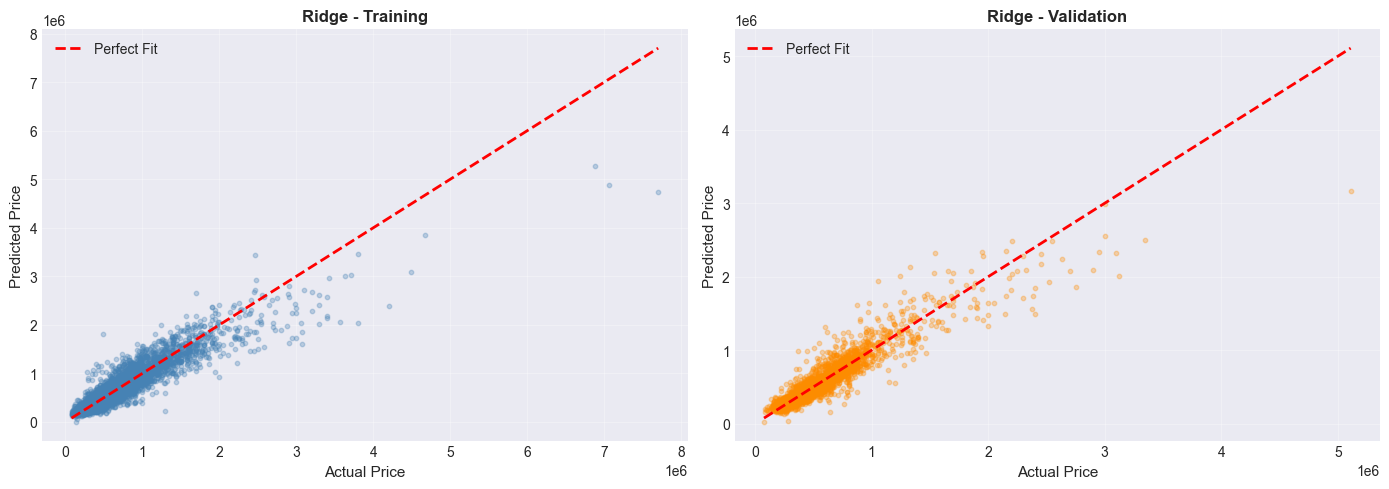


Training Lasso...

Lasso Results:
-----------------------------------------------------------------
Metric       Train              Validation         Gap         
-----------------------------------------------------------------
RMSE         129676.8770        128900.2090        -0.6%       
MAE          75580.8577         77233.9440         +2.2%       
R2           0.8715             0.8676             +0.0039     
MAPE         14.6115            14.7224            +0.8%       


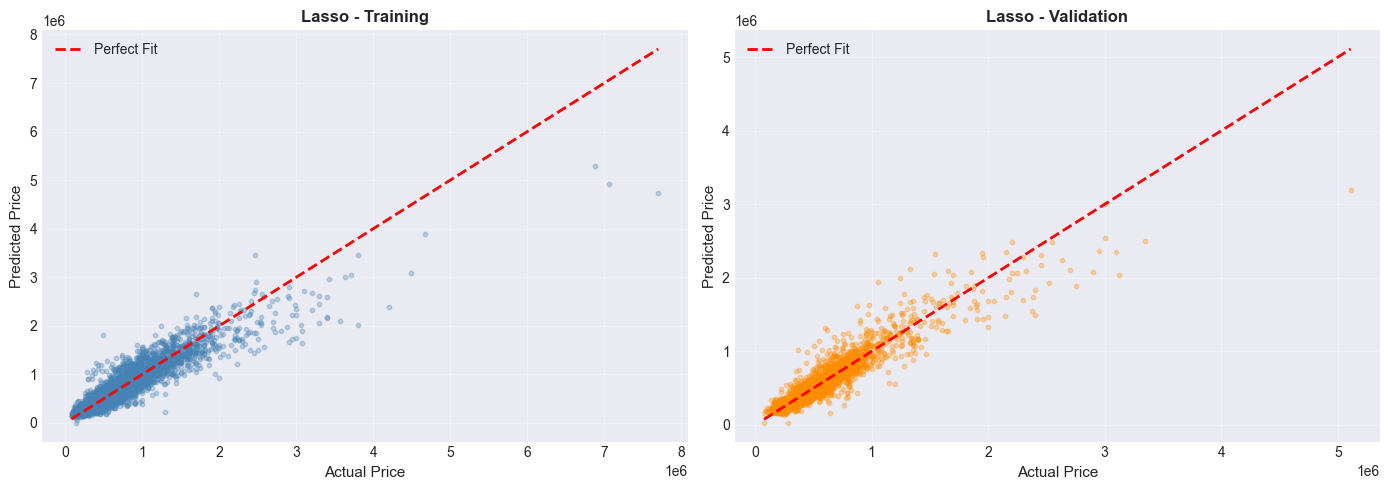


Training ElasticNet...

ElasticNet Results:
-----------------------------------------------------------------
Metric       Train              Validation         Gap         
-----------------------------------------------------------------
RMSE         148397.8337        155044.1710        +4.5%       
MAE          84401.9858         87127.2786         +3.2%       
R2           0.8318             0.8084             +0.0233     
MAPE         16.1603            16.2876            +0.8%       


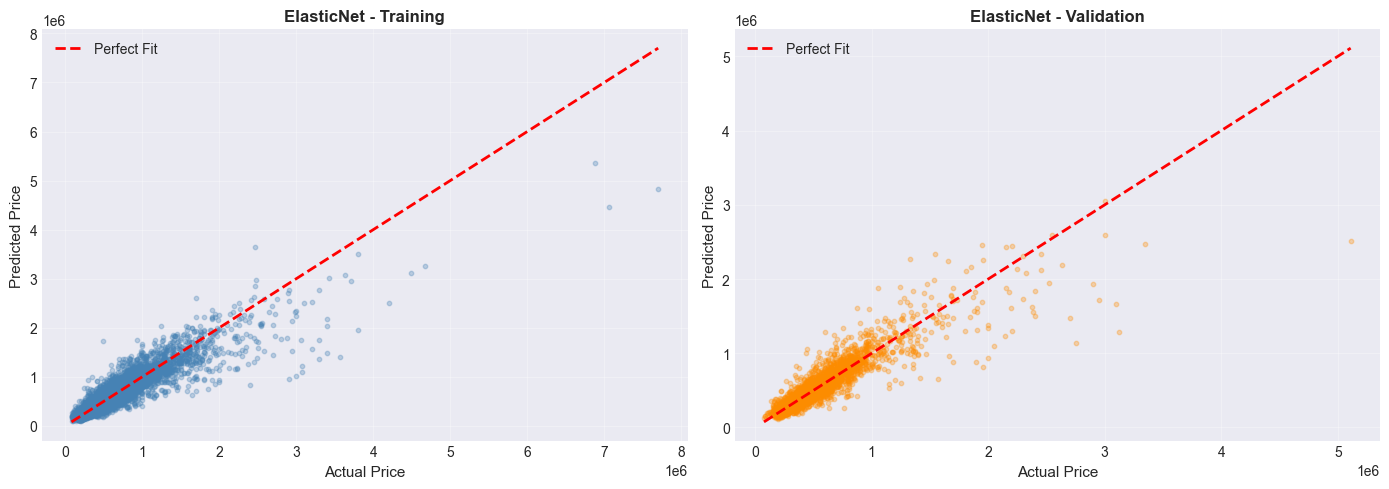


Training RandomForest...

RandomForest Results:
-----------------------------------------------------------------
Metric       Train              Validation         Gap         
-----------------------------------------------------------------
RMSE         46497.4043         122771.7723        +164.0%     
MAE          26560.6061         69052.1007         +160.0%     
R2           0.9835             0.8799             +0.1036     
MAPE         5.1980             13.0065            +150.2%     


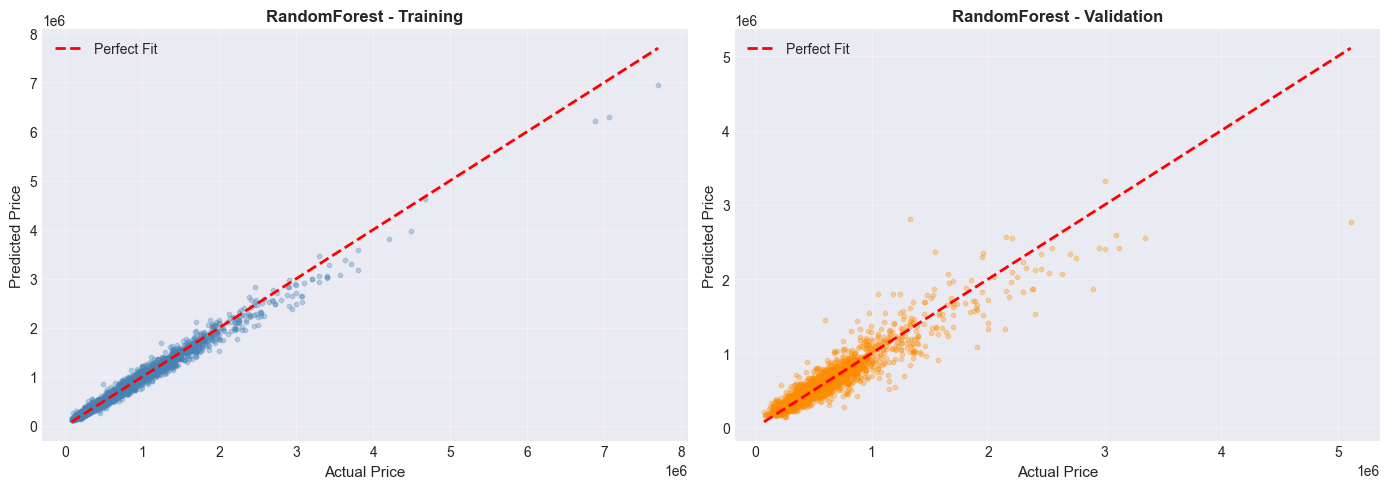


Training GradientBoosting...

GradientBoosting Results:
-----------------------------------------------------------------
Metric       Train              Validation         Gap         
-----------------------------------------------------------------
RMSE         71979.4632         116875.0042        +62.4%      
MAE          50699.4059         67045.4855         +32.2%      
R2           0.9604             0.8911             +0.0693     
MAPE         10.9697            12.7088            +15.9%      


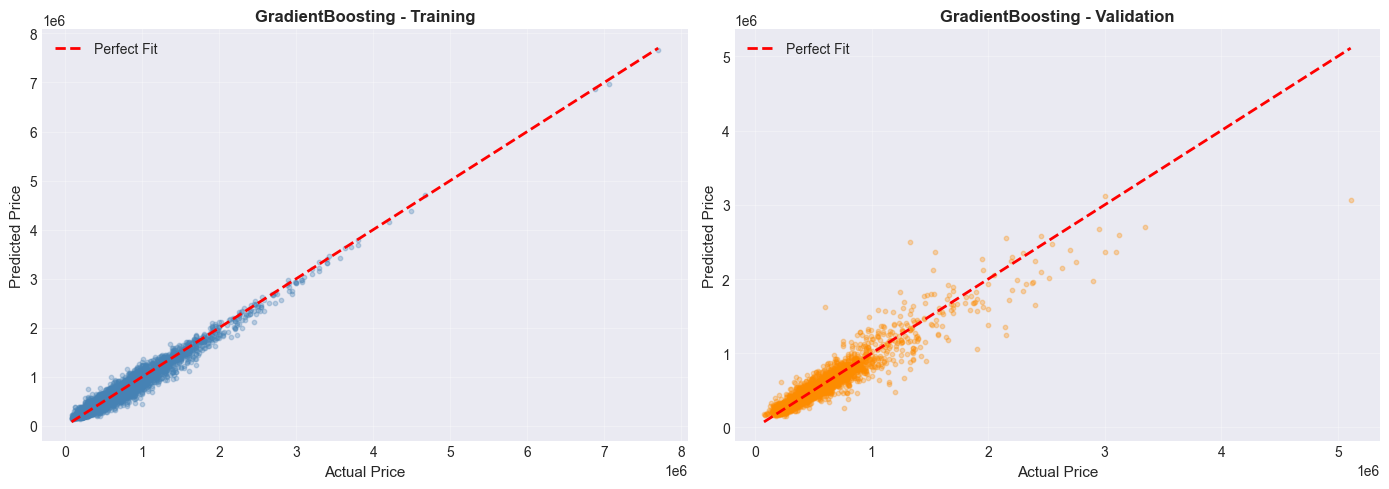


Training XGBoost...

XGBoost Results:
-----------------------------------------------------------------
Metric       Train              Validation         Gap         
-----------------------------------------------------------------
RMSE         53631.1313         110740.5992        +106.5%     
MAE          38761.4688         65420.0234         +68.8%      
R2           0.9780             0.9023             +0.0758     
MAPE         8.8989             12.4262            +39.6%      


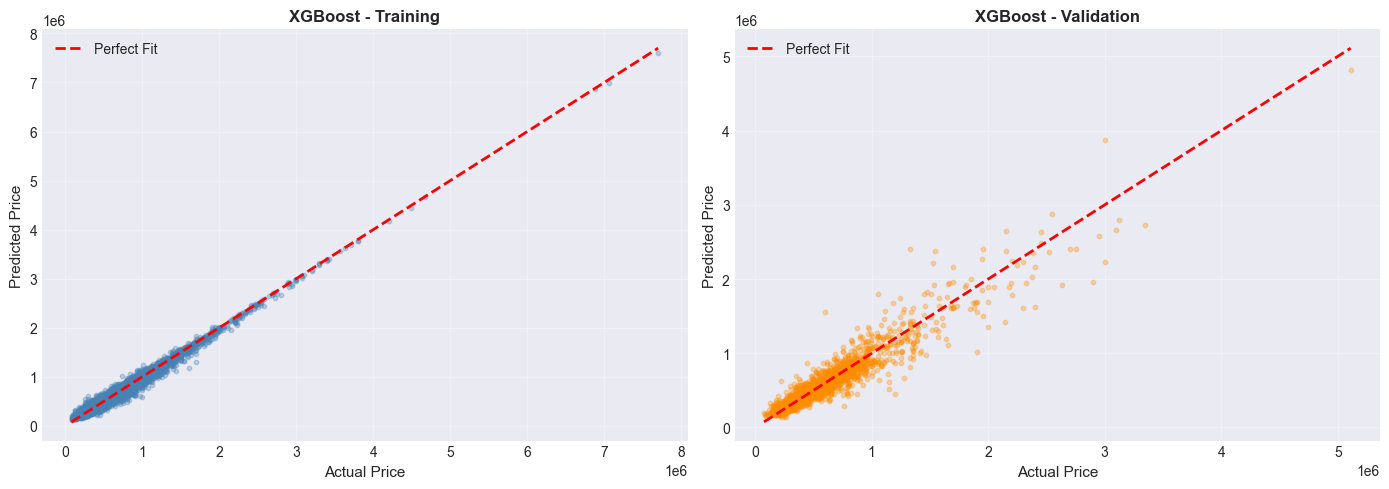


Training LightGBM...

LightGBM Results:
-----------------------------------------------------------------
Metric       Train              Validation         Gap         
-----------------------------------------------------------------
RMSE         87337.3932         114557.9291        +31.2%      
MAE          54718.6062         67471.3968         +23.3%      
R2           0.9417             0.8954             +0.0463     
MAPE         11.4333            12.7902            +11.9%      


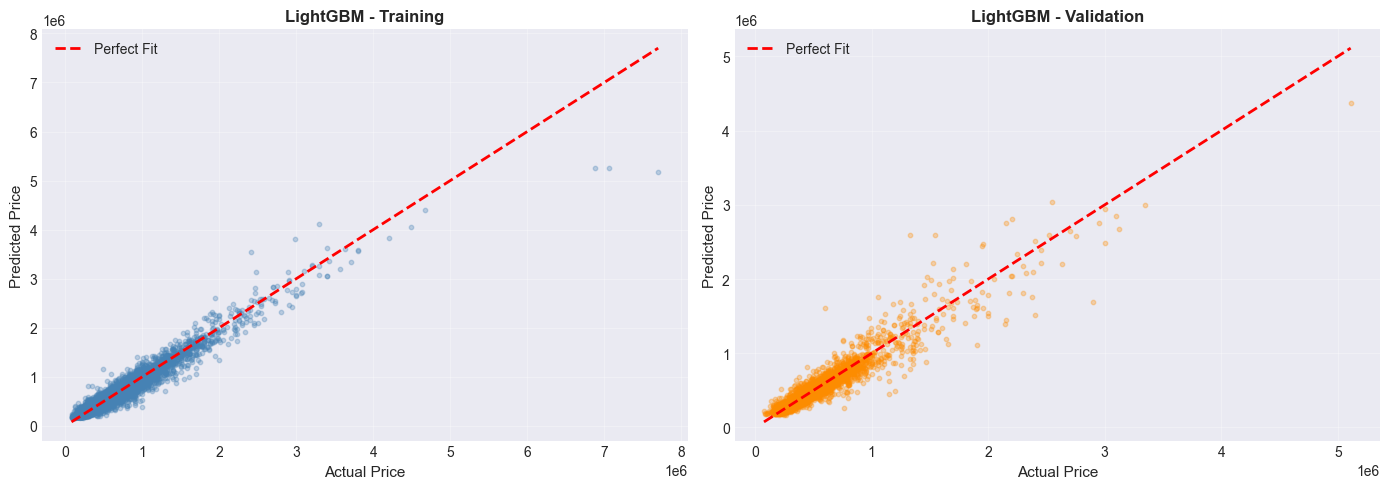


Tabular-only models completed


In [32]:
print("=" * 80)
print("BASELINE MODELS - TABULAR ONLY")
print("=" * 80)

tabular_model_results = {}

tabular_model_configs = {
    'Ridge': Ridge(alpha=10.0),
    'Lasso': Lasso(alpha=100.0, max_iter=5000),
    'ElasticNet': ElasticNet(alpha=100.0, l1_ratio=0.5, max_iter=5000),
    'RandomForest': RandomForestRegressor(n_estimators=100, max_depth=20, random_state=cfg.SEED, n_jobs=-1),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=cfg.SEED),
    'XGBoost': XGBRegressor(n_estimators=100, max_depth=7, learning_rate=0.1, random_state=cfg.SEED, n_jobs=-1),
    'LightGBM': LGBMRegressor(n_estimators=100, max_depth=7, learning_rate=0.1, random_state=cfg.SEED, n_jobs=-1, verbose=-1),
}

for model_name, model_instance in tabular_model_configs.items():
    trained_model, tr_metrics, va_metrics, y_tr_pred, y_va_pred = train_evaluate_ml_model(
        model_instance, X_train_tabular, y_train_original, X_val_tabular, y_val_original, model_name
    )
    
    tabular_model_results[model_name] = {
        'model': trained_model,
        'train_metrics': tr_metrics,
        'val_metrics': va_metrics,
        'train_predictions': y_tr_pred,
        'val_predictions': y_va_pred
    }
    
    visualize_predictions(y_train_original, y_tr_pred, y_val_original, y_va_pred, model_name)

print("\nTabular-only models completed")

## 6. Baseline Models - Image Only (CNN Features)

BASELINE MODELS - IMAGE ONLY (CNN Features)

Training Ridge_CNN...

Ridge_CNN Results:
-----------------------------------------------------------------
Metric       Train              Validation         Gap         
-----------------------------------------------------------------
RMSE         274733.7297        278407.4592        +1.3%       
MAE          171139.5000        182103.9531        +6.4%       
R2           0.4233             0.3823             +0.0410     
MAPE         36.5080            39.3850            +7.9%       


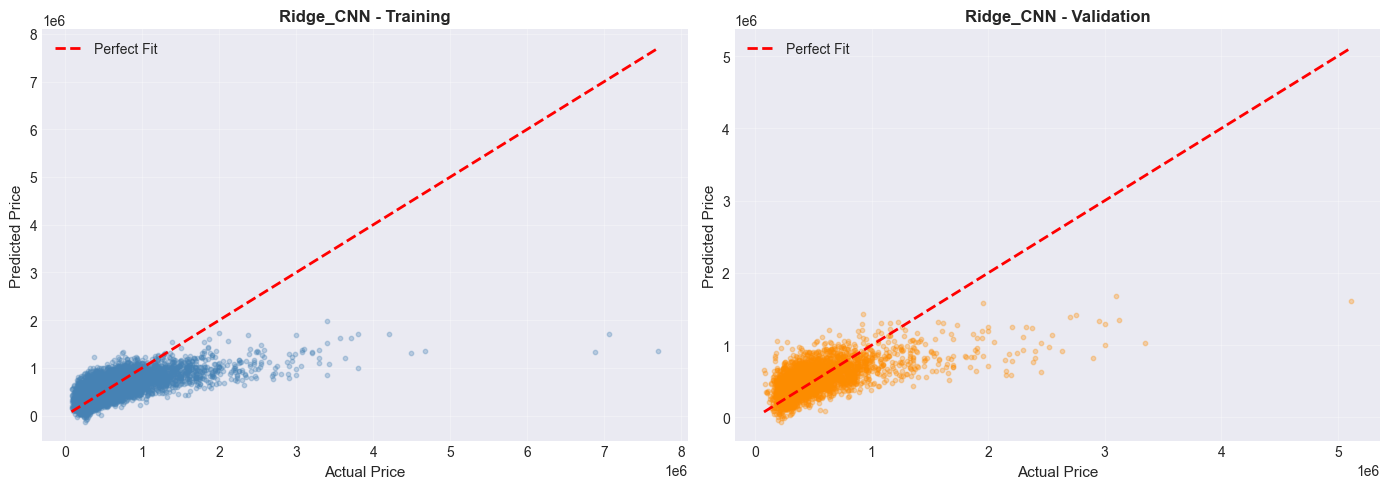


Training RandomForest_CNN...

RandomForest_CNN Results:
-----------------------------------------------------------------
Metric       Train              Validation         Gap         
-----------------------------------------------------------------
RMSE         184879.0942        308884.6640        +67.1%      
MAE          133915.8687        192957.0226        +44.1%      
R2           0.7389             0.2397             +0.4992     
MAPE         30.7415            42.0740            +36.9%      


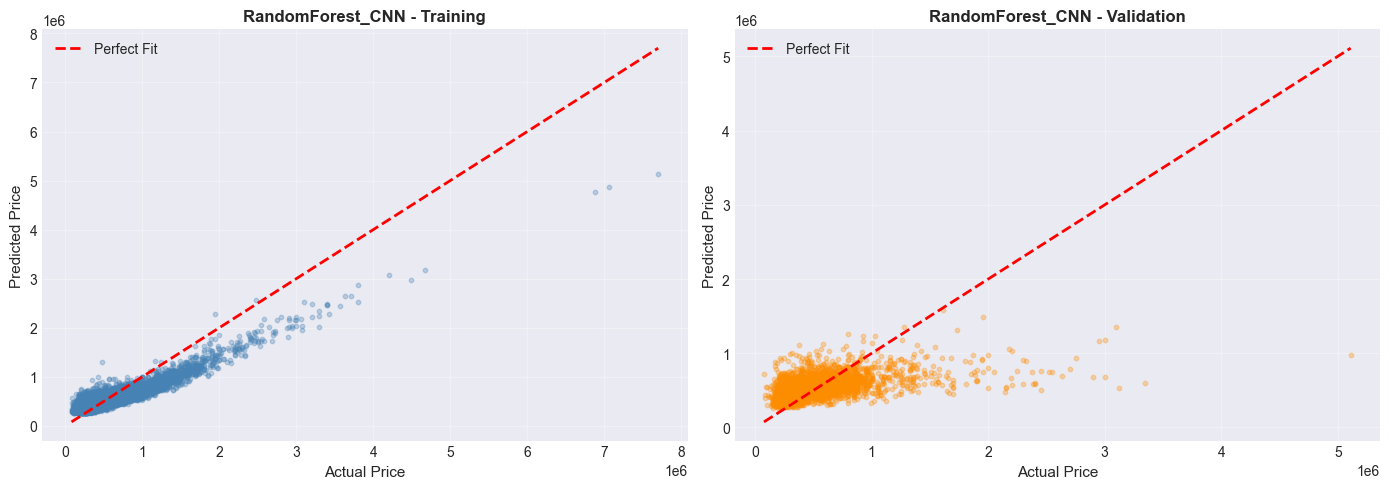


Training XGBoost_CNN...

XGBoost_CNN Results:
-----------------------------------------------------------------
Metric       Train              Validation         Gap         
-----------------------------------------------------------------
RMSE         177058.5187        294223.0703        +66.2%      
MAE          127128.8750        184702.8125        +45.3%      
R2           0.7605             0.3102             +0.4503     
MAPE         28.3793            39.0204            +37.5%      


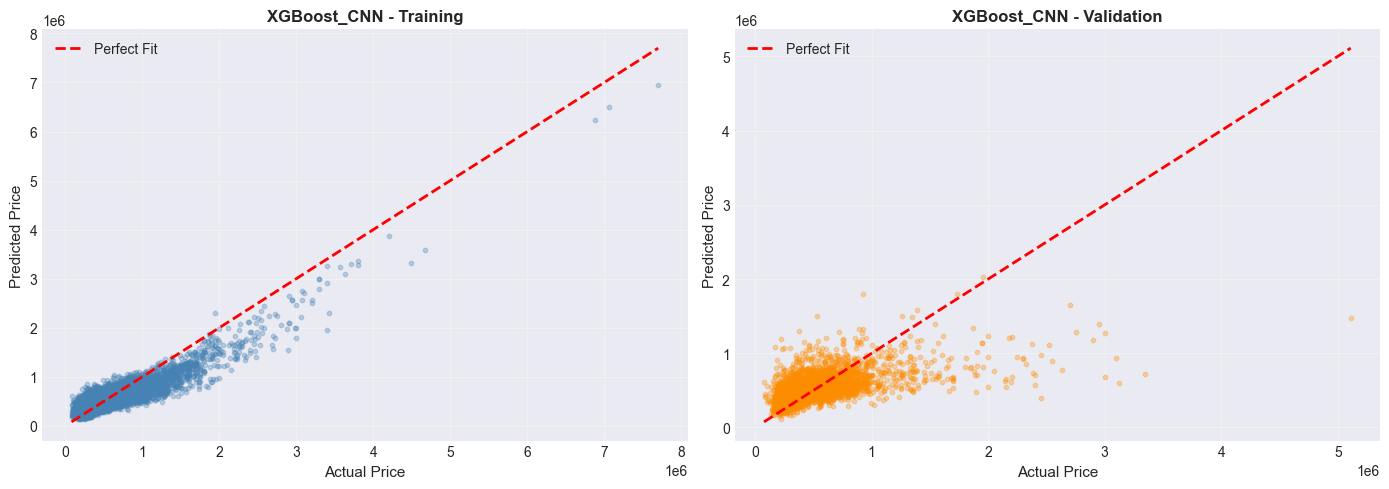


Training LightGBM_CNN...

LightGBM_CNN Results:
-----------------------------------------------------------------
Metric       Train              Validation         Gap         
-----------------------------------------------------------------
RMSE         197832.5431        287814.3687        +45.5%      
MAE          133626.4644        183203.1825        +37.1%      
R2           0.7010             0.3399             +0.3611     
MAPE         29.0532            38.8666            +33.8%      


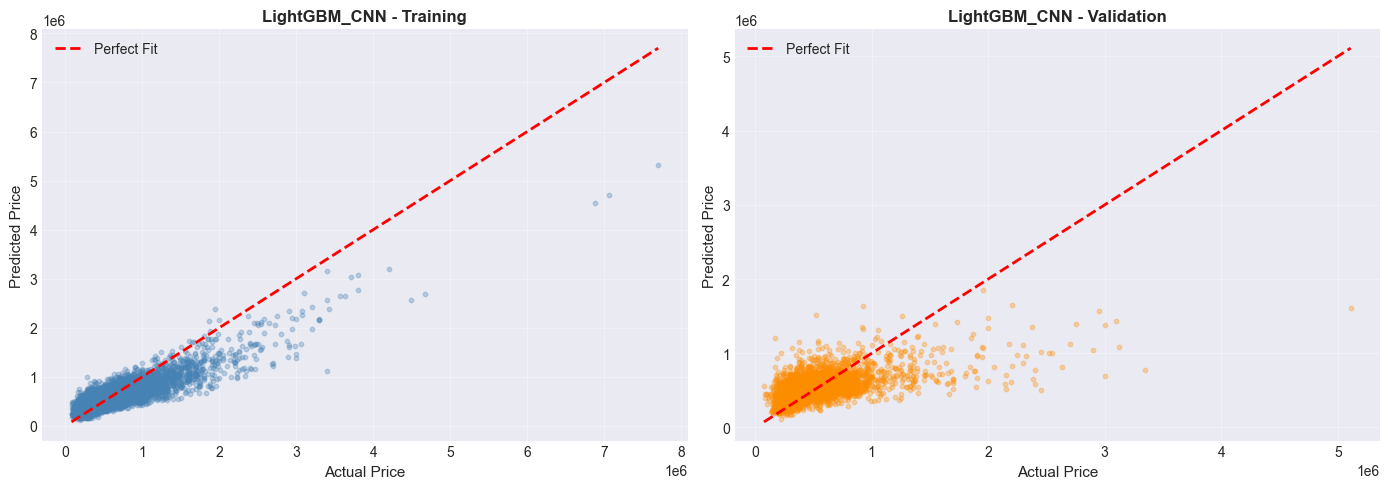


Image-only models completed


In [33]:
print("=" * 80)
print("BASELINE MODELS - IMAGE ONLY (CNN Features)")
print("=" * 80)

image_model_results = {}

image_model_configs = {
    'Ridge_CNN': Ridge(alpha=100.0),
    'RandomForest_CNN': RandomForestRegressor(n_estimators=100, max_depth=15, random_state=cfg.SEED, n_jobs=-1),
    'XGBoost_CNN': XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=cfg.SEED, n_jobs=-1),
    'LightGBM_CNN': LGBMRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=cfg.SEED, n_jobs=-1, verbose=-1),
}

for model_name, model_instance in image_model_configs.items():
    trained_model, tr_metrics, va_metrics, y_tr_pred, y_va_pred = train_evaluate_ml_model(
        model_instance, X_train_cnn, y_train_original, X_val_cnn, y_val_original, model_name
    )
    
    image_model_results[model_name] = {
        'model': trained_model,
        'train_metrics': tr_metrics,
        'val_metrics': va_metrics,
        'train_predictions': y_tr_pred,
        'val_predictions': y_va_pred
    }
    
    visualize_predictions(y_train_original, y_tr_pred, y_val_original, y_va_pred, model_name)

print("\nImage-only models completed")

## 8. ML Model Comparison

In [36]:
def compile_model_results(tabular_res, image_res):
    """Compile all ML model results into a DataFrame"""
    
    all_results = []
    
    for name, res in tabular_res.items():
        all_results.append({
            'Model': name,
            'Category': 'Tabular',
            'Train_RMSE': res['train_metrics']['RMSE'],
            'Val_RMSE': res['val_metrics']['RMSE'],
            'Train_R2': res['train_metrics']['R2'],
            'Val_R2': res['val_metrics']['R2'],
            'Train_MAE': res['train_metrics']['MAE'],
            'Val_MAE': res['val_metrics']['MAE']
        })
    
    for name, res in image_res.items():
        all_results.append({
            'Model': name,
            'Category': 'Image',
            'Train_RMSE': res['train_metrics']['RMSE'],
            'Val_RMSE': res['val_metrics']['RMSE'],
            'Train_R2': res['train_metrics']['R2'],
            'Val_R2': res['val_metrics']['R2'],
            'Train_MAE': res['train_metrics']['MAE'],
            'Val_MAE': res['val_metrics']['MAE']
        })
    
    return pd.DataFrame(all_results).sort_values('Val_RMSE')

In [37]:
ml_comparison_df = compile_model_results(tabular_model_results, image_model_results)

print("\n" + "=" * 80)
print("ML MODELS COMPARISON (Sorted by Validation RMSE)")
print("=" * 80)
print(ml_comparison_df.to_string(index=False))

top_ml_model = ml_comparison_df.iloc[0]
print(f"\nBest ML Model: {top_ml_model['Model']} ({top_ml_model['Category']})")
print(f"  Validation RMSE: ${top_ml_model['Val_RMSE']:,.2f}")
print(f"  Validation R2: {top_ml_model['Val_R2']:.4f}")


ML MODELS COMPARISON (Sorted by Validation RMSE)
           Model Category    Train_RMSE      Val_RMSE  Train_R2   Val_R2     Train_MAE       Val_MAE
         XGBoost  Tabular  53631.131258 110740.599240  0.978025 0.902274  38761.468750  65420.023438
        LightGBM  Tabular  87337.393152 114557.929143  0.941723 0.895421  54718.606192  67471.396788
GradientBoosting  Tabular  71979.463175 116875.004242  0.960417 0.891147  50699.405870  67045.485488
    RandomForest  Tabular  46497.404285 122771.772290  0.983482 0.879886  26560.606108  69052.100673
           Lasso  Tabular 129676.877045 128900.209032  0.871524 0.867595  75580.857744  77233.944027
           Ridge  Tabular 129718.634698 129209.054739  0.871441 0.866960  75629.206569  77397.127585
      ElasticNet  Tabular 148397.833733 155044.171021  0.831751 0.808439  84401.985817  87127.278567
       Ridge_CNN    Image 274733.729651 278407.459210  0.423339 0.382329 171139.500000 182103.953125
    LightGBM_CNN    Image 197832.543068 2

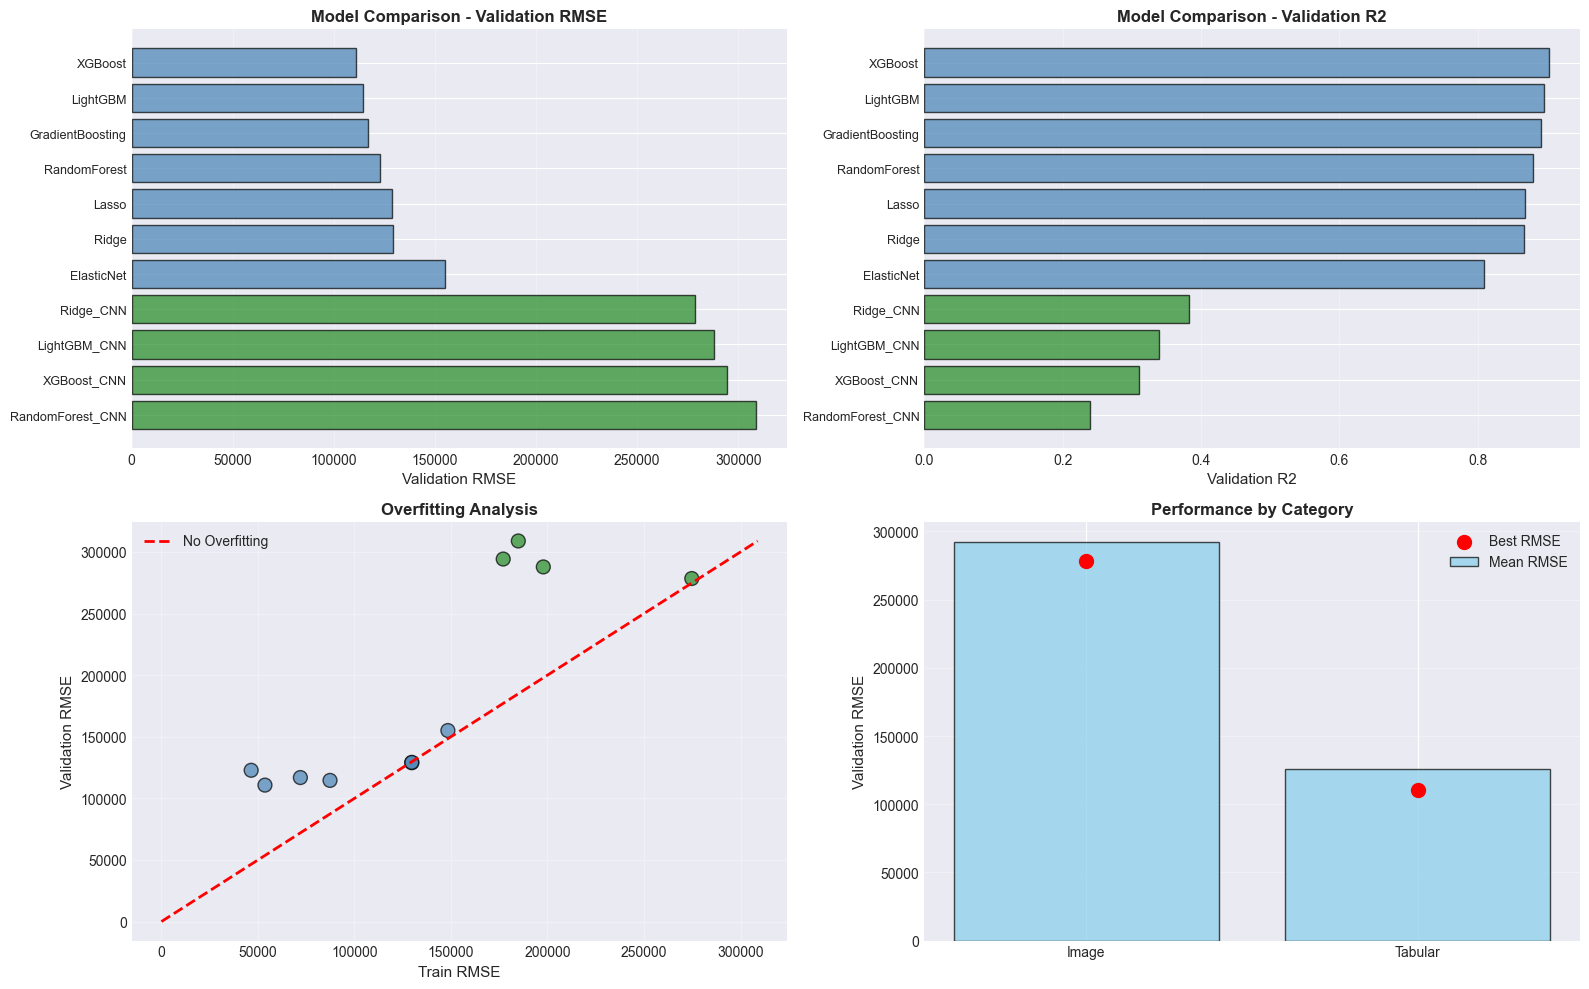

In [38]:
# Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

category_colors = {'Tabular': 'steelblue', 'Image': 'forestgreen', 'Multimodal': 'crimson'}
colors = [category_colors[c] for c in ml_comparison_df['Category']]

axes[0, 0].barh(range(len(ml_comparison_df)), ml_comparison_df['Val_RMSE'],
                color=colors, alpha=0.7, edgecolor='black')
axes[0, 0].set_yticks(range(len(ml_comparison_df)))
axes[0, 0].set_yticklabels(ml_comparison_df['Model'], fontsize=9)
axes[0, 0].set_xlabel('Validation RMSE', fontsize=11)
axes[0, 0].set_title('Model Comparison - Validation RMSE', fontsize=12, fontweight='bold')
axes[0, 0].invert_yaxis()
axes[0, 0].grid(axis='x', alpha=0.3)

axes[0, 1].barh(range(len(ml_comparison_df)), ml_comparison_df['Val_R2'],
                color=colors, alpha=0.7, edgecolor='black')
axes[0, 1].set_yticks(range(len(ml_comparison_df)))
axes[0, 1].set_yticklabels(ml_comparison_df['Model'], fontsize=9)
axes[0, 1].set_xlabel('Validation R2', fontsize=11)
axes[0, 1].set_title('Model Comparison - Validation R2', fontsize=12, fontweight='bold')
axes[0, 1].invert_yaxis()
axes[0, 1].grid(axis='x', alpha=0.3)

axes[1, 0].scatter(ml_comparison_df['Train_RMSE'], ml_comparison_df['Val_RMSE'],
                   c=colors, s=100, alpha=0.7, edgecolor='black')
max_rmse = max(ml_comparison_df['Train_RMSE'].max(), ml_comparison_df['Val_RMSE'].max())
axes[1, 0].plot([0, max_rmse], [0, max_rmse], 'r--', lw=2, label='No Overfitting')
axes[1, 0].set_xlabel('Train RMSE', fontsize=11)
axes[1, 0].set_ylabel('Validation RMSE', fontsize=11)
axes[1, 0].set_title('Overfitting Analysis', fontsize=12, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

category_perf = ml_comparison_df.groupby('Category')['Val_RMSE'].agg(['mean', 'min']).reset_index()
x_pos = range(len(category_perf))
axes[1, 1].bar(x_pos, category_perf['mean'], alpha=0.7, label='Mean RMSE', color='skyblue', edgecolor='black')
axes[1, 1].scatter(x_pos, category_perf['min'], s=100, color='red', label='Best RMSE', zorder=5)
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels(category_perf['Category'])
axes[1, 1].set_ylabel('Validation RMSE', fontsize=11)
axes[1, 1].set_title('Performance by Category', fontsize=12, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Deep Learning Models

### 9.1 Multimodal Dataset

In [39]:
class MultimodalPropertyDataset(Dataset):
    """Dataset combining images and tabular features with normalized targets"""
    
    def __init__(self, dataframe, image_dir, tabular_cols, image_col='image_path', transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.image_dir = image_dir
        self.tabular_cols = tabular_cols
        self.image_col = image_col
        self.transform = transform
        
        self.valid_indices = []
        for idx in range(len(self.dataframe)):
            img_path = os.path.join(self.image_dir, str(self.dataframe.loc[idx, self.image_col]))
            if os.path.exists(img_path):
                self.valid_indices.append(idx)
        
        print(f"Dataset: {len(self.valid_indices)}/{len(self.dataframe)} valid samples")
    
    def __len__(self):
        return len(self.valid_indices)
    
    def __getitem__(self, idx):
        actual_idx = self.valid_indices[idx]
        
        img_name = self.dataframe.loc[actual_idx, self.image_col]
        img_path = os.path.join(self.image_dir, str(img_name))
        
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        
        tabular_features = self.dataframe.loc[actual_idx, self.tabular_cols].values.astype(np.float32)
        tabular_tensor = torch.tensor(tabular_features, dtype=torch.float32)
        
        target_value = torch.tensor(self.dataframe.loc[actual_idx, 'price_normalized'], dtype=torch.float32)
        
        return {
            'image': image,
            'tabular': tabular_tensor,
            'target': target_value
        }

In [40]:
dl_transform = transforms.Compose([
    transforms.Resize((cfg.IMG_SIZE, cfg.IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGE_MEAN, std=IMAGE_STD)
])

train_dl_dataset = MultimodalPropertyDataset(training_data, cfg.IMAGE_DIRECTORY, feature_columns, transform=dl_transform)
val_dl_dataset = MultimodalPropertyDataset(validation_data, cfg.IMAGE_DIRECTORY, feature_columns, transform=dl_transform)

train_dl_loader = DataLoader(
    train_dl_dataset,
    batch_size=cfg.BATCH_SIZE,
    shuffle=True,
    num_workers=cfg.NUM_WORKERS,
    pin_memory=False,
    persistent_workers=False
)

val_dl_loader = DataLoader(
    val_dl_dataset,
    batch_size=cfg.BATCH_SIZE,
    shuffle=False,
    num_workers=cfg.NUM_WORKERS,
    pin_memory=False,
    persistent_workers=False
)

print(f"\nDataLoaders created:")
print(f"  Training batches: {len(train_dl_loader)}")
print(f"  Validation batches: {len(val_dl_loader)}")

Dataset: 12967/12967 valid samples
Dataset: 3242/3242 valid samples

DataLoaders created:
  Training batches: 406
  Validation batches: 102


In [51]:
def unfreeze_backbone_stage(model, backbone_name, stage_name):
    """
    Unfreeze a specific stage of the CNN backbone returned by BackboneFactory
    """
    backbone_name = backbone_name.lower()
    stage_map = BACKBONE_STAGE_MAP[backbone_name]

    if stage_name not in stage_map:
        raise ValueError(f"Stage {stage_name} not defined for {backbone_name}")

    stage_idx = stage_map[stage_name]
    stage_module = model.image_backbone[stage_idx]

    for p in stage_module.parameters():
        p.requires_grad = True

    print(f"Unfroze {backbone_name}:{stage_name}")

In [135]:
BACKBONE_UNFREEZE_SCHEDULE = {
    "resnet50": {
        5: "layer4",
    },
    "resnet101": {
        5: "layer4",
    },
    "efficientnet_b0": {
        5: "features"
    },
    "densenet121": {
        5: "features"
    },
    "inception_v3": {
        6  : "Mixed_7c"
    }
}


In [120]:
def build_optimizer(model, backbone_name):
    param_groups = [
        {"params": model.image_head.parameters(), "lr": 1e-4},
        {"params": model.tabular_branch.parameters(), "lr": 1e-3},
        {"params": model.fusion_layers.parameters(), "lr": 1e-3},
    ]

    backbone_name = backbone_name.lower()

    # Add unfrozen backbone params dynamically
    backbone = model.image_backbone
    for p in backbone.parameters():
        if p.requires_grad:
            param_groups.append(
                {"params": [p], "lr": 1e-5}
            )

    return torch.optim.AdamW(param_groups, weight_decay=1e-4)

### 9.2 Multimodal Architecture

In [121]:
class MultimodalPropertyNetwork(nn.Module):
    """
    End-to-end multimodal architecture for property price prediction.
    
    Architecture:
    - Image branch: CNN backbone -> feature head
    - Tabular branch: MLP
    - Fusion: Concatenation -> MLP -> Output
    """
    
    def __init__(self, num_tabular_features, backbone_name='resnet50', dropout_rate=0.3):
        super(MultimodalPropertyNetwork, self).__init__()
        
        self.backbone_name = backbone_name
        
        # Image branch
        self.image_backbone, self.cnn_output_dim, self.gradcam_target = BackboneFactory.get_backbone(backbone_name)
        
        
        # Freeze backbone initially
        for param in self.image_backbone.parameters():
            param.requires_grad = False
        
        # Image feature head
        self.image_head = nn.Sequential(
            nn.Linear(self.cnn_output_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 128)
        )
        
        # Tabular branch
        self.tabular_branch = nn.Sequential(
            nn.Linear(num_tabular_features, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 64)
        )
        
        # Fusion layers
        fusion_dim = 128 + 64
        self.fusion_layers = nn.Sequential(
            nn.Linear(fusion_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout_rate / 2),
            nn.Linear(128, 1)
        )
    
    def forward(self, image_input, tabular_input):
        # Image branch
        img_features = self.image_backbone(image_input)
        img_features = torch.flatten(img_features, 1)
        img_features = self.image_head(img_features)
        
        # Tabular branch
        tab_features = self.tabular_branch(tabular_input)
        
        # Fusion
        combined = torch.cat([img_features, tab_features], dim=1)
        output = self.fusion_layers(combined)
        
        return output.squeeze()

In [122]:
# Initialize model
num_features = len(feature_columns)
dl_model = MultimodalPropertyNetwork(num_tabular_features=num_features, backbone_name='resnet50').to(DEVICE)

total_parameters = sum(p.numel() for p in dl_model.parameters())
trainable_parameters = sum(p.numel() for p in dl_model.parameters() if p.requires_grad)

print(f"\nModel Architecture Summary:")
print(f"  Total parameters: {total_parameters:,}")
print(f"  Trainable parameters: {trainable_parameters:,}")


Model Architecture Summary:
  Total parameters: 24,203,137
  Trainable parameters: 695,105


### 9.3 Training Function

In [138]:
def train_deep_learning_model(
    model,
    train_loader,
    val_loader,
    num_epochs=25,
    target_mean=None,
    target_std=None,
    model_save_path=None,
):


    loss_function = nn.MSELoss()



    # Build optimizer using your function
    optimizer = build_optimizer(model, model.backbone_name)

    # ReduceLROnPlateau scheduler (better for your problem)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3
    )

    training_history = {
        "train_loss": [], "val_loss": [],
        "train_rmse": [], "val_rmse": [],
        "train_mae": [], "val_mae": [],
        "train_r2": [], "val_r2": [],
        "learning_rates": []
    }

    best_val_r2 = -float("inf")
    best_val_loss = float("inf")
    best_model_weights = None
    patience_counter = 0
    plateau_counter = 0

    backbone_schedule = BACKBONE_UNFREEZE_SCHEDULE.get(
        model.backbone_name, {}
    )

    print("\n" + "=" * 80)
    print("DEEP LEARNING MODEL TRAINING (ReduceLROnPlateau)")
    print("=" * 80)
    print(f"Backbone: {model.backbone_name}")
    print(f"Unfreeze schedule: {backbone_schedule if backbone_schedule else 'FROZEN THROUGHOUT'}")
    print("=" * 80)

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        print("-" * 65)

        # =========================
        #  Progressive unfreezing
        # =========================
        if epoch in backbone_schedule:
            stage = backbone_schedule[epoch]
            print(f"Unfreezing backbone stage: {stage}")
            unfreeze_backbone_stage(model, model.backbone_name, stage)

            # Rebuild optimizer with new params
            optimizer = build_optimizer(model, model.backbone_name)
            
            # Rebuild scheduler
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer,
                mode='max',
                factor=0.5,
                patience=3,
                min_lr=1e-7,
                threshold=0.001,
            )
            print("Scheduler rebuilt after unfreezing")

        # =========================
        # Training
        # =========================
        model.train()
        epoch_train_loss = 0.0
        train_preds, train_targets = [], []

        for batch in tqdm(train_loader, desc="Training"):
            images = batch["image"].to(DEVICE)
            tabular = batch["tabular"].to(DEVICE)
            targets = batch["target"].to(DEVICE)

            optimizer.zero_grad()
            outputs = model(images, tabular)
            loss = loss_function(outputs, targets)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            epoch_train_loss += loss.item()
            train_preds.append(outputs.detach().cpu())
            train_targets.append(targets.detach().cpu())

        epoch_train_loss /= len(train_loader)

        train_preds = torch.cat(train_preds).numpy()
        train_targets = torch.cat(train_targets).numpy()

        # Denormalize predictions for interpretable metrics
        train_preds_orig = inverse_transform_predictions(
            train_preds, target_mean, target_std
        )
        train_targets_orig = inverse_transform_predictions(
            train_targets, target_mean, target_std
        )

        train_rmse = np.sqrt(mean_squared_error(train_targets_orig, train_preds_orig))
        train_mae = mean_absolute_error(train_targets_orig, train_preds_orig)
        train_r2 = r2_score(train_targets_orig, train_preds_orig)

        # =========================
        # Validation
        # =========================
        model.eval()
        epoch_val_loss = 0.0
        val_preds, val_targets = [], []

        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validation"):
                images = batch["image"].to(DEVICE)
                tabular = batch["tabular"].to(DEVICE)
                targets = batch["target"].to(DEVICE)

                outputs = model(images, tabular)
                loss = loss_function(outputs, targets)

                epoch_val_loss += loss.item()
                val_preds.append(outputs.cpu())
                val_targets.append(targets.cpu())

        epoch_val_loss /= len(val_loader)

        val_preds = torch.cat(val_preds).numpy()
        val_targets = torch.cat(val_targets).numpy()

        # Denormalize predictions for interpretable metrics
        val_preds_orig = inverse_transform_predictions(
            val_preds, target_mean, target_std
        )
        val_targets_orig = inverse_transform_predictions(
            val_targets, target_mean, target_std
        )

        val_rmse = np.sqrt(mean_squared_error(val_targets_orig, val_preds_orig))
        val_mae = mean_absolute_error(val_targets_orig, val_preds_orig)
        val_r2 = r2_score(val_targets_orig, val_preds_orig)

        # =========================
        # Track learning rates
        # =========================
        current_lrs = {}
        for idx, param_group in enumerate(optimizer.param_groups):
            current_lrs[f'group_{idx}'] = param_group['lr']

        # =========================
        # Logging
        # =========================
        training_history["train_loss"].append(epoch_train_loss)
        training_history["val_loss"].append(epoch_val_loss)
        training_history["train_rmse"].append(train_rmse)
        training_history["val_rmse"].append(val_rmse)
        training_history["train_mae"].append(train_mae)
        training_history["val_mae"].append(val_mae)
        training_history["train_r2"].append(train_r2)
        training_history["val_r2"].append(val_r2)
        training_history["learning_rates"].append(current_lrs)

        # Print epoch summary
        print(f"\nEpoch {epoch+1} Summary")
        print(f"{'Metric':<15} {'Train':<20} {'Validation':<20}")
        print("-" * 55)
        print(f"{'Loss (Norm)':<15} {epoch_train_loss:<20.4f} {epoch_val_loss:<20.4f}")
        print(f"{'RMSE ($)':<15} {train_rmse:<20,.2f} {val_rmse:<20,.2f}")
        print(f"{'MAE ($)':<15} {train_mae:<20,.2f} {val_mae:<20,.2f}")
        print(f"{'R²':<15} {train_r2:<20.4f} {val_r2:<20.4f}")
        
        # Display sample learning rates
        print(f"LRs: ", end="")
        for key, lr in list(current_lrs.items())[:3]:  # Show first 3 groups
            print(f"{key}={lr:.2e} ", end="")
        print()

        # =========================
        # Learning rate scheduling
        # =========================
        old_lr = optimizer.param_groups[0]['lr']
        scheduler.step(val_r2)  # Step based on validation R²
        new_lr = optimizer.param_groups[0]['lr']
        
        if new_lr < old_lr:
            plateau_counter += 1
            print(f"Plateau detected! LR reduced: {old_lr:.2e} -> {new_lr:.2e}")

        # =========================
        # Checkpointing (use R² as primary metric)
        # =========================
        if val_r2 > best_val_r2:
            improvement = val_r2 - best_val_r2
            best_val_r2 = val_r2
            best_val_loss = epoch_val_loss
            best_model_weights = model.state_dict()
            patience_counter = 0

            if model_save_path:
                torch.save({
                    'model_state_dict': model.state_dict(),
                    'val_r2': val_r2,
                    'val_rmse': val_rmse,
                    'val_mae': val_mae,
                    'epoch': epoch,
                    'training_history': training_history
                }, model_save_path)
            print(f"New best R²: {val_r2:.4f} (+{improvement:.4f})")

        else:
            patience_counter += 1

        # =========================
        # Early stopping
        # =========================
        if patience_counter >= cfg.EARLY_STOP_PATIENCE:
            print(f"Early stopping at epoch {epoch+1}")
            break
        
        # Stop if LR too low
        if optimizer.param_groups[0]['lr'] < 1e-7:
            print("LR dropped below minimum, stopping")
            break

    # =========================
    # Final summary
    # =========================
    model.load_state_dict(best_model_weights)
    
    print("\n" + "=" * 80)
    print("TRAINING COMPLETED")
    print("=" * 80)
    print(f"Best Val R²: {best_val_r2:.4f}")
    print(f"Best Val RMSE: ${val_rmse:,.2f}")
    print(f"Best Val MAE: ${val_mae:,.2f}")
    print(f"Plateau reductions: {plateau_counter}")
    print("=" * 80)

    return model, training_history



### 9.4 Train Model

In [72]:
# Initialize and train model
dl_model = MultimodalPropertyNetwork(
    num_tabular_features=len(feature_columns), 
    backbone_name='resnet50'
).to(DEVICE)

model_path = os.path.join(cfg.MODEL_DIR, 'resnet50_best.pth')

trained_dl_model, dl_training_history = train_deep_learning_model(
    dl_model,
    train_dl_loader,
    val_dl_loader,
    num_epochs=cfg.NUM_EPOCHS,
    target_mean=target_mean,
    target_std=target_std,
    model_save_path=model_path
)

print(f"\nModel saved to: {model_path}")


DEEP LEARNING MODEL TRAINING (Cosine LR)

Epoch 1/15
-----------------------------------------------------------------


Validation: 100%|██████████| 102/102 [00:33<00:00,  3.03it/s]



Epoch 1 Summary
Train RMSE: 400,346.44 | Val RMSE: 375,412.47
Train MAE : 234,480.37 | Val MAE : 222,152.03
Train R²  : -0.2245 | Val R²  : -0.1231
 New best model saved

Epoch 2/15
-----------------------------------------------------------------


Validation: 100%|██████████| 102/102 [00:33<00:00,  3.03it/s]



Epoch 2 Summary
Train RMSE: 386,873.08 | Val RMSE: 360,113.33
Train MAE : 223,896.27 | Val MAE : 211,508.44
Train R²  : -0.1435 | Val R²  : -0.0334
 New best model saved

Epoch 3/15
-----------------------------------------------------------------


Validation: 100%|██████████| 102/102 [00:33<00:00,  3.03it/s]



Epoch 3 Summary
Train RMSE: 224,378.94 | Val RMSE: 168,735.37
Train MAE : 119,475.60 | Val MAE : 88,871.05
Train R²  : 0.6154 | Val R²  : 0.7731
 New best model saved

Epoch 4/15
-----------------------------------------------------------------


Validation: 100%|██████████| 102/102 [00:33<00:00,  3.03it/s]



Epoch 4 Summary
Train RMSE: 206,030.38 | Val RMSE: 160,331.06
Train MAE : 105,935.27 | Val MAE : 87,444.10
Train R²  : 0.6757 | Val R²  : 0.7952
 New best model saved

Epoch 5/15
-----------------------------------------------------------------


Validation: 100%|██████████| 102/102 [00:38<00:00,  2.66it/s]



Epoch 5 Summary
Train RMSE: 190,205.02 | Val RMSE: 152,390.09
Train MAE : 101,150.35 | Val MAE : 83,893.06
Train R²  : 0.7236 | Val R²  : 0.8149
 New best model saved

Epoch 6/15
-----------------------------------------------------------------
🔓 Unfreezing backbone stage: layer4
Unfroze resnet50:layer4


Validation: 100%|██████████| 102/102 [00:39<00:00,  2.60it/s]



Epoch 6 Summary
Train RMSE: 192,290.42 | Val RMSE: 152,958.93
Train MAE : 99,794.68 | Val MAE : 84,535.35
Train R²  : 0.7175 | Val R²  : 0.8136

Epoch 7/15
-----------------------------------------------------------------


Validation: 100%|██████████| 102/102 [00:33<00:00,  3.01it/s]



Epoch 7 Summary
Train RMSE: 191,101.17 | Val RMSE: 145,713.27
Train MAE : 98,744.78 | Val MAE : 81,732.28
Train R²  : 0.7210 | Val R²  : 0.8308
 New best model saved

Epoch 8/15
-----------------------------------------------------------------


Validation: 100%|██████████| 102/102 [00:34<00:00,  2.94it/s]



Epoch 8 Summary
Train RMSE: 175,083.84 | Val RMSE: 161,117.39
Train MAE : 90,663.44 | Val MAE : 90,553.36
Train R²  : 0.7658 | Val R²  : 0.7931

Epoch 9/15
-----------------------------------------------------------------


Validation: 100%|██████████| 102/102 [00:34<00:00,  2.99it/s]



Epoch 9 Summary
Train RMSE: 169,303.33 | Val RMSE: 154,975.18
Train MAE : 84,782.39 | Val MAE : 85,625.24
Train R²  : 0.7810 | Val R²  : 0.8086

Epoch 10/15
-----------------------------------------------------------------
🔓 Unfreezing backbone stage: layer3
Unfroze resnet50:layer3


Validation: 100%|██████████| 102/102 [00:34<00:00,  2.98it/s]



Epoch 10 Summary
Train RMSE: 153,223.22 | Val RMSE: 150,570.45
Train MAE : 77,980.02 | Val MAE : 87,266.27
Train R²  : 0.8206 | Val R²  : 0.8193

Epoch 11/15
-----------------------------------------------------------------


Validation: 100%|██████████| 102/102 [00:34<00:00,  2.97it/s]



Epoch 11 Summary
Train RMSE: 151,468.04 | Val RMSE: 149,731.51
Train MAE : 78,460.86 | Val MAE : 85,314.36
Train R²  : 0.8247 | Val R²  : 0.8213

Epoch 12/15
-----------------------------------------------------------------


Validation: 100%|██████████| 102/102 [00:34<00:00,  2.97it/s]



Epoch 12 Summary
Train RMSE: 157,216.60 | Val RMSE: 151,325.67
Train MAE : 76,954.53 | Val MAE : 87,736.85
Train R²  : 0.8112 | Val R²  : 0.8175

Epoch 13/15
-----------------------------------------------------------------


Validation: 100%|██████████| 102/102 [00:34<00:00,  2.98it/s]



Epoch 13 Summary
Train RMSE: 152,948.21 | Val RMSE: 157,897.43
Train MAE : 75,927.82 | Val MAE : 90,951.46
Train R²  : 0.8213 | Val R²  : 0.8013

Epoch 14/15
-----------------------------------------------------------------


Validation: 100%|██████████| 102/102 [00:33<00:00,  3.01it/s]



Epoch 14 Summary
Train RMSE: 147,536.52 | Val RMSE: 149,791.75
Train MAE : 74,915.96 | Val MAE : 85,190.42
Train R²  : 0.8337 | Val R²  : 0.8212

Epoch 15/15
-----------------------------------------------------------------


Validation: 100%|██████████| 102/102 [00:34<00:00,  3.00it/s]


Epoch 15 Summary
Train RMSE: 145,009.75 | Val RMSE: 152,917.60
Train MAE : 74,673.24 | Val MAE : 89,518.50
Train R²  : 0.8393 | Val R²  : 0.8137
⏹ Early stopping triggered

Training completed. Best Val Loss: 0.0699

Model saved to: saved_models/resnet50_best.pth


In [139]:
resnet50_model = MultimodalPropertyNetwork(
    num_tabular_features=len(feature_columns), 
    backbone_name='resnet50'
).to(DEVICE)

model_path = os.path.join(cfg.MODEL_DIR, 'resnet50_new_best.pth')

trained_resnet50_model, resnet50_training_history = train_deep_learning_model(
    resnet50_model,
    train_dl_loader,
    val_dl_loader,
    num_epochs=cfg.NUM_EPOCHS,
    target_mean=target_mean,
    target_std=target_std,
    model_save_path=model_path
)

print(f"\nModel saved to: {model_path}")


DEEP LEARNING MODEL TRAINING (ReduceLROnPlateau)
Backbone: resnet50
Unfreeze schedule: {5: 'layer4'}

Epoch 1/15
-----------------------------------------------------------------


Validation: 100%|██████████| 102/102 [00:35<00:00,  2.86it/s]



Epoch 1 Summary
Metric          Train                Validation          
-------------------------------------------------------
Loss (Norm)     0.2577               0.1560              
RMSE ($)        215,334.05           223,152.51          
MAE ($)         114,295.75           91,964.80           
R²              0.6457               0.6032              
LRs: group_0=1.00e-04 group_1=1.00e-03 group_2=1.00e-03 
New best R²: 0.6032 (+inf)

Epoch 2/15
-----------------------------------------------------------------


Validation: 100%|██████████| 102/102 [00:36<00:00,  2.81it/s]



Epoch 2 Summary
Metric          Train                Validation          
-------------------------------------------------------
Loss (Norm)     0.2066               0.1832              
RMSE ($)        196,169.68           185,569.80          
MAE ($)         102,181.08           98,382.27           
R²              0.7060               0.7256              
LRs: group_0=1.00e-04 group_1=1.00e-03 group_2=1.00e-03 
New best R²: 0.7256 (+0.1224)

Epoch 3/15
-----------------------------------------------------------------


Validation: 100%|██████████| 102/102 [00:34<00:00,  2.96it/s]



Epoch 3 Summary
Metric          Train                Validation          
-------------------------------------------------------
Loss (Norm)     0.2015               0.1662              
RMSE ($)        193,755.58           162,237.83          
MAE ($)         100,183.50           91,492.25           
R²              0.7132               0.7903              
LRs: group_0=1.00e-04 group_1=1.00e-03 group_2=1.00e-03 
New best R²: 0.7903 (+0.0647)

Epoch 4/15
-----------------------------------------------------------------


Validation: 100%|██████████| 102/102 [00:34<00:00,  2.94it/s]



Epoch 4 Summary
Metric          Train                Validation          
-------------------------------------------------------
Loss (Norm)     0.1933               0.1598              
RMSE ($)        181,838.85           150,843.05          
MAE ($)         98,191.47            85,091.01           
R²              0.7474               0.8187              
LRs: group_0=1.00e-04 group_1=1.00e-03 group_2=1.00e-03 
New best R²: 0.8187 (+0.0284)

Epoch 5/15
-----------------------------------------------------------------


Validation: 100%|██████████| 102/102 [00:34<00:00,  2.97it/s]



Epoch 5 Summary
Metric          Train                Validation          
-------------------------------------------------------
Loss (Norm)     0.1858               0.1660              
RMSE ($)        182,671.04           182,386.11          
MAE ($)         96,422.79            91,250.63           
R²              0.7451               0.7349              
LRs: group_0=1.00e-04 group_1=1.00e-03 group_2=1.00e-03 
Plateau detected! LR reduced: 1.00e-04 -> 5.00e-05

Epoch 6/15
-----------------------------------------------------------------
Unfreezing backbone stage: layer4
Unfroze resnet50:layer4
Scheduler rebuilt after unfreezing


Validation: 100%|██████████| 102/102 [00:34<00:00,  2.92it/s]



Epoch 6 Summary
Metric          Train                Validation          
-------------------------------------------------------
Loss (Norm)     0.1877               0.2096              
RMSE ($)        184,485.65           309,596.89          
MAE ($)         97,823.96            112,510.48          
R²              0.7400               0.2362              
LRs: group_0=1.00e-04 group_1=1.00e-03 group_2=1.00e-03 

Epoch 7/15
-----------------------------------------------------------------


Validation: 100%|██████████| 102/102 [00:34<00:00,  2.93it/s]



Epoch 7 Summary
Metric          Train                Validation          
-------------------------------------------------------
Loss (Norm)     0.1710               0.1493              
RMSE ($)        175,740.92           155,091.77          
MAE ($)         93,808.24            84,568.44           
R²              0.7640               0.8083              
LRs: group_0=1.00e-04 group_1=1.00e-03 group_2=1.00e-03 

Epoch 8/15
-----------------------------------------------------------------


Validation: 100%|██████████| 102/102 [00:35<00:00,  2.90it/s]



Epoch 8 Summary
Metric          Train                Validation          
-------------------------------------------------------
Loss (Norm)     0.1490               0.1924              
RMSE ($)        167,447.91           160,429.87          
MAE ($)         87,941.73            94,354.78           
R²              0.7858               0.7949              
LRs: group_0=1.00e-04 group_1=1.00e-03 group_2=1.00e-03 

Epoch 9/15
-----------------------------------------------------------------


Validation: 100%|██████████| 102/102 [00:34<00:00,  2.92it/s]



Epoch 9 Summary
Metric          Train                Validation          
-------------------------------------------------------
Loss (Norm)     0.1297               0.1720              
RMSE ($)        151,707.83           173,301.14          
MAE ($)         82,168.57            91,364.06           
R²              0.8242               0.7607              
LRs: group_0=1.00e-04 group_1=1.00e-03 group_2=1.00e-03 

Epoch 10/15
-----------------------------------------------------------------


Validation: 100%|██████████| 102/102 [00:35<00:00,  2.91it/s]



Epoch 10 Summary
Metric          Train                Validation          
-------------------------------------------------------
Loss (Norm)     0.1173               0.1835              
RMSE ($)        151,489.00           160,703.68          
MAE ($)         79,583.57            93,333.56           
R²              0.8247               0.7942              
LRs: group_0=1.00e-04 group_1=1.00e-03 group_2=1.00e-03 

Epoch 11/15
-----------------------------------------------------------------


Validation: 100%|██████████| 102/102 [00:35<00:00,  2.89it/s]



Epoch 11 Summary
Metric          Train                Validation          
-------------------------------------------------------
Loss (Norm)     0.1047               0.1687              
RMSE ($)        146,530.54           156,499.11          
MAE ($)         75,105.21            88,834.07           
R²              0.8360               0.8048              
LRs: group_0=1.00e-04 group_1=1.00e-03 group_2=1.00e-03 
Plateau detected! LR reduced: 1.00e-04 -> 5.00e-05

Epoch 12/15
-----------------------------------------------------------------


Validation: 100%|██████████| 102/102 [00:35<00:00,  2.88it/s]



Epoch 12 Summary
Metric          Train                Validation          
-------------------------------------------------------
Loss (Norm)     0.0984               0.1594              
RMSE ($)        145,593.44           150,037.11          
MAE ($)         73,286.17            85,371.70           
R²              0.8381               0.8206              
LRs: group_0=5.00e-05 group_1=5.00e-04 group_2=5.00e-04 
New best R²: 0.8206 (+0.0019)

Epoch 13/15
-----------------------------------------------------------------


Validation: 100%|██████████| 102/102 [00:34<00:00,  2.95it/s]



Epoch 13 Summary
Metric          Train                Validation          
-------------------------------------------------------
Loss (Norm)     0.0835               0.1903              
RMSE ($)        134,294.71           175,205.38          
MAE ($)         67,257.54            95,410.86           
R²              0.8622               0.7554              
LRs: group_0=5.00e-05 group_1=5.00e-04 group_2=5.00e-04 

Epoch 14/15
-----------------------------------------------------------------


Validation: 100%|██████████| 102/102 [00:34<00:00,  2.99it/s]



Epoch 14 Summary
Metric          Train                Validation          
-------------------------------------------------------
Loss (Norm)     0.0830               0.1775              
RMSE ($)        132,312.10           154,868.05          
MAE ($)         67,026.95            89,385.32           
R²              0.8662               0.8089              
LRs: group_0=5.00e-05 group_1=5.00e-04 group_2=5.00e-04 

Epoch 15/15
-----------------------------------------------------------------


Validation: 100%|██████████| 102/102 [00:34<00:00,  2.99it/s]


Epoch 15 Summary
Metric          Train                Validation          
-------------------------------------------------------
Loss (Norm)     0.0796               0.1848              
RMSE ($)        126,874.75           168,283.38          
MAE ($)         66,705.48            93,438.35           
R²              0.8770               0.7743              
LRs: group_0=5.00e-05 group_1=5.00e-04 group_2=5.00e-04 

TRAINING COMPLETED
Best Val R²: 0.8206
Best Val RMSE: $168,283.38
Best Val MAE: $93,438.35
Plateau reductions: 2

Model saved to: saved_models/resnet50_new_best.pth


In [89]:
inceptionv3_model = MultimodalPropertyNetwork(
    num_tabular_features=len(feature_columns), 
    backbone_name='inception_v3'
).to(DEVICE)

model_path = os.path.join(cfg.MODEL_DIR, 'inceptionv3_best.pth')

trained_inceptionv3_model, inceptionv3_training_history = train_deep_learning_model(
    inceptionv3_model,
    train_dl_loader,
    val_dl_loader,
    num_epochs=cfg.NUM_EPOCHS,
    target_mean=target_mean,
    target_std=target_std,
    model_save_path=model_path
)

print(f"\nModel saved to: {model_path}")


DEEP LEARNING MODEL TRAINING (Cosine LR)

Epoch 1/15
-----------------------------------------------------------------


Validation: 100%|██████████| 102/102 [00:30<00:00,  3.39it/s]



Epoch 1 Summary
Train RMSE: 362,257.23 | Val RMSE: 358,846.60
Train MAE : 233,322.22 | Val MAE : 222,941.35
Train R²  : -0.0026 | Val R²  : -0.0262
 New best model saved

Epoch 2/15
-----------------------------------------------------------------


Validation: 100%|██████████| 102/102 [00:29<00:00,  3.44it/s]



Epoch 2 Summary
Train RMSE: 349,438.04 | Val RMSE: 357,513.84
Train MAE : 222,468.35 | Val MAE : 212,636.98
Train R²  : 0.0671 | Val R²  : -0.0185
 New best model saved

Epoch 3/15
-----------------------------------------------------------------


Validation: 100%|██████████| 102/102 [00:29<00:00,  3.50it/s]



Epoch 3 Summary
Train RMSE: 228,780.13 | Val RMSE: 173,319.77
Train MAE : 121,566.64 | Val MAE : 92,704.41
Train R²  : 0.6001 | Val R²  : 0.7606
 New best model saved

Epoch 4/15
-----------------------------------------------------------------


Validation: 100%|██████████| 102/102 [00:29<00:00,  3.46it/s]



Epoch 4 Summary
Train RMSE: 204,787.15 | Val RMSE: 149,304.06
Train MAE : 106,108.11 | Val MAE : 81,642.33
Train R²  : 0.6796 | Val R²  : 0.8224
 New best model saved

Epoch 5/15
-----------------------------------------------------------------


Validation: 100%|██████████| 102/102 [00:29<00:00,  3.51it/s]



Epoch 5 Summary
Train RMSE: 198,043.11 | Val RMSE: 169,973.23
Train MAE : 101,893.69 | Val MAE : 94,923.51
Train R²  : 0.7003 | Val R²  : 0.7698

Epoch 6/15
-----------------------------------------------------------------


Validation: 100%|██████████| 102/102 [00:29<00:00,  3.51it/s]



Epoch 6 Summary
Train RMSE: 193,086.67 | Val RMSE: 157,396.80
Train MAE : 102,355.68 | Val MAE : 88,882.13
Train R²  : 0.7152 | Val R²  : 0.8026

Epoch 7/15
-----------------------------------------------------------------
🔓 Unfreezing backbone stage: Mixed_7c
Unfroze inception_v3:Mixed_7c


Validation: 100%|██████████| 102/102 [00:29<00:00,  3.45it/s]



Epoch 7 Summary
Train RMSE: 202,527.54 | Val RMSE: 197,598.39
Train MAE : 101,259.74 | Val MAE : 105,251.39
Train R²  : 0.6866 | Val R²  : 0.6889

Epoch 8/15
-----------------------------------------------------------------


Validation: 100%|██████████| 102/102 [00:30<00:00,  3.33it/s]



Epoch 8 Summary
Train RMSE: 184,341.42 | Val RMSE: 163,341.29
Train MAE : 97,180.67 | Val MAE : 87,055.14
Train R²  : 0.7404 | Val R²  : 0.7874

Epoch 9/15
-----------------------------------------------------------------


Validation: 100%|██████████| 102/102 [00:30<00:00,  3.38it/s]



Epoch 9 Summary
Train RMSE: 179,927.64 | Val RMSE: 153,625.43
Train MAE : 95,683.41 | Val MAE : 84,260.60
Train R²  : 0.7527 | Val R²  : 0.8119

Epoch 10/15
-----------------------------------------------------------------


Validation: 100%|██████████| 102/102 [00:31<00:00,  3.28it/s]



Epoch 10 Summary
Train RMSE: 178,055.74 | Val RMSE: 147,294.16
Train MAE : 94,238.01 | Val MAE : 83,876.71
Train R²  : 0.7578 | Val R²  : 0.8271

Epoch 11/15
-----------------------------------------------------------------


Validation: 100%|██████████| 102/102 [00:29<00:00,  3.42it/s]



Epoch 11 Summary
Train RMSE: 175,203.83 | Val RMSE: 171,060.60
Train MAE : 94,361.73 | Val MAE : 85,040.79
Train R²  : 0.7655 | Val R²  : 0.7668

Epoch 12/15
-----------------------------------------------------------------


Validation: 100%|██████████| 102/102 [00:30<00:00,  3.34it/s]


Epoch 12 Summary
Train RMSE: 175,522.70 | Val RMSE: 152,289.54
Train MAE : 93,293.65 | Val MAE : 84,684.02
Train R²  : 0.7646 | Val R²  : 0.8152
⏹ Early stopping triggered

Training completed. Best Val Loss: 0.0716

Model saved to: saved_models/inceptionv3_best.pth


In [105]:
resnet101_model = MultimodalPropertyNetwork(
    num_tabular_features=len(feature_columns), 
    backbone_name='resnet101'
).to(DEVICE)

model_path = os.path.join(cfg.MODEL_DIR, 'resnet101_best.pth')

trained_resnet101_model, resnet101_training_history = train_deep_learning_model(
    resnet101_model,
    train_dl_loader,
    val_dl_loader,
    num_epochs=cfg.NUM_EPOCHS,
    target_mean=target_mean,
    target_std=target_std,
    model_save_path=model_path
)

print(f"\nModel saved to: {model_path}")


DEEP LEARNING MODEL TRAINING (Cosine LR)

Epoch 1/15
-----------------------------------------------------------------


Validation: 100%|██████████| 102/102 [00:45<00:00,  2.23it/s]



Epoch 1 Summary
Train RMSE: 366,158.05 | Val RMSE: 344,665.91
Train MAE : 219,844.49 | Val MAE : 208,530.26
Train R²  : -0.0243 | Val R²  : 0.0533
 New best model saved

Epoch 2/15
-----------------------------------------------------------------


Validation: 100%|██████████| 102/102 [00:45<00:00,  2.24it/s]



Epoch 2 Summary
Train RMSE: 352,966.11 | Val RMSE: 322,074.34
Train MAE : 207,124.70 | Val MAE : 192,178.05
Train R²  : 0.0482 | Val R²  : 0.1734
 New best model saved

Epoch 3/15
-----------------------------------------------------------------


Validation: 100%|██████████| 102/102 [00:45<00:00,  2.25it/s]



Epoch 3 Summary
Train RMSE: 223,223.52 | Val RMSE: 181,599.82
Train MAE : 121,053.35 | Val MAE : 94,543.65
Train R²  : 0.6193 | Val R²  : 0.7372
 New best model saved

Epoch 4/15
-----------------------------------------------------------------


Validation: 100%|██████████| 102/102 [00:45<00:00,  2.24it/s]



Epoch 4 Summary
Train RMSE: 201,295.24 | Val RMSE: 190,927.93
Train MAE : 104,991.70 | Val MAE : 100,998.79
Train R²  : 0.6904 | Val R²  : 0.7095

Epoch 5/15
-----------------------------------------------------------------


Validation: 100%|██████████| 102/102 [00:45<00:00,  2.22it/s]



Epoch 5 Summary
Train RMSE: 185,073.10 | Val RMSE: 184,552.76
Train MAE : 100,564.75 | Val MAE : 97,290.67
Train R²  : 0.7383 | Val R²  : 0.7286

Epoch 6/15
-----------------------------------------------------------------
🔓 Unfreezing backbone stage: layer4
Unfroze resnet101:layer4


Validation: 100%|██████████| 102/102 [00:45<00:00,  2.26it/s]



Epoch 6 Summary
Train RMSE: 209,345.26 | Val RMSE: 184,926.25
Train MAE : 102,771.64 | Val MAE : 97,501.97
Train R²  : 0.6652 | Val R²  : 0.7275

Epoch 7/15
-----------------------------------------------------------------


Validation: 100%|██████████| 102/102 [00:45<00:00,  2.23it/s]



Epoch 7 Summary
Train RMSE: 189,298.73 | Val RMSE: 157,188.38
Train MAE : 98,892.84 | Val MAE : 87,713.11
Train R²  : 0.7262 | Val R²  : 0.8031
 New best model saved

Epoch 8/15
-----------------------------------------------------------------


Validation: 100%|██████████| 102/102 [00:45<00:00,  2.25it/s]



Epoch 8 Summary
Train RMSE: 168,516.22 | Val RMSE: 152,059.83
Train MAE : 93,234.66 | Val MAE : 85,367.06
Train R²  : 0.7830 | Val R²  : 0.8157
 New best model saved

Epoch 9/15
-----------------------------------------------------------------


Validation: 100%|██████████| 102/102 [00:45<00:00,  2.26it/s]



Epoch 9 Summary
Train RMSE: 171,048.53 | Val RMSE: 156,477.34
Train MAE : 87,886.21 | Val MAE : 88,708.46
Train R²  : 0.7765 | Val R²  : 0.8049

Epoch 10/15
-----------------------------------------------------------------


Validation: 100%|██████████| 102/102 [00:45<00:00,  2.24it/s]



Epoch 10 Summary
Train RMSE: 157,311.79 | Val RMSE: 153,736.87
Train MAE : 80,098.02 | Val MAE : 88,105.86
Train R²  : 0.8109 | Val R²  : 0.8117

Epoch 11/15
-----------------------------------------------------------------


Validation: 100%|██████████| 102/102 [00:45<00:00,  2.24it/s]



Epoch 11 Summary
Train RMSE: 155,009.69 | Val RMSE: 155,403.37
Train MAE : 77,264.87 | Val MAE : 88,645.01
Train R²  : 0.8164 | Val R²  : 0.8076

Epoch 12/15
-----------------------------------------------------------------


Validation: 100%|██████████| 102/102 [00:45<00:00,  2.23it/s]



Epoch 12 Summary
Train RMSE: 155,841.19 | Val RMSE: 165,775.87
Train MAE : 78,305.60 | Val MAE : 94,605.81
Train R²  : 0.8144 | Val R²  : 0.7810

Epoch 13/15
-----------------------------------------------------------------


Validation: 100%|██████████| 102/102 [00:45<00:00,  2.23it/s]



Epoch 13 Summary
Train RMSE: 153,806.35 | Val RMSE: 151,560.91
Train MAE : 77,234.57 | Val MAE : 87,786.72
Train R²  : 0.8193 | Val R²  : 0.8169

Epoch 14/15
-----------------------------------------------------------------


Validation: 100%|██████████| 102/102 [00:45<00:00,  2.23it/s]



Epoch 14 Summary
Train RMSE: 156,106.44 | Val RMSE: 152,020.81
Train MAE : 78,256.75 | Val MAE : 86,635.04
Train R²  : 0.8138 | Val R²  : 0.8158

Epoch 15/15
-----------------------------------------------------------------


Validation: 100%|██████████| 102/102 [00:45<00:00,  2.23it/s]


Epoch 15 Summary
Train RMSE: 148,810.56 | Val RMSE: 156,715.43
Train MAE : 77,349.20 | Val MAE : 87,334.04
Train R²  : 0.8308 | Val R²  : 0.8043

Training completed. Best Val Loss: 0.0766

Model saved to: saved_models/resnet101_best.pth


In [106]:
efficientnet_b0_model = MultimodalPropertyNetwork(
    num_tabular_features=len(feature_columns), 
    backbone_name='efficientnet_b0'
).to(DEVICE)

model_path = os.path.join(cfg.MODEL_DIR, 'efficientnet_b0_best.pth')

trained_efficientnet_b0_model, efficientnet_b0_training_history = train_deep_learning_model(
    efficientnet_b0_model,
    train_dl_loader,
    val_dl_loader,
    num_epochs=cfg.NUM_EPOCHS,
    target_mean=target_mean,
    target_std=target_std,
    model_save_path=model_path
)

print(f"\nModel saved to: {model_path}")


DEEP LEARNING MODEL TRAINING (Cosine LR)

Epoch 1/15
-----------------------------------------------------------------


Validation: 100%|██████████| 102/102 [00:25<00:00,  4.06it/s]



Epoch 1 Summary
Train RMSE: 367,431.03 | Val RMSE: 352,397.76
Train MAE : 221,199.18 | Val MAE : 210,804.96
Train R²  : -0.0315 | Val R²  : 0.0104
 New best model saved

Epoch 2/15
-----------------------------------------------------------------


Validation: 100%|██████████| 102/102 [00:24<00:00,  4.13it/s]



Epoch 2 Summary
Train RMSE: 353,265.82 | Val RMSE: 338,455.95
Train MAE : 209,469.56 | Val MAE : 200,250.00
Train R²  : 0.0465 | Val R²  : 0.0871
 New best model saved

Epoch 3/15
-----------------------------------------------------------------


Validation: 100%|██████████| 102/102 [00:24<00:00,  4.14it/s]



Epoch 3 Summary
Train RMSE: 226,049.33 | Val RMSE: 211,461.28
Train MAE : 119,072.18 | Val MAE : 96,290.63
Train R²  : 0.6096 | Val R²  : 0.6437
 New best model saved

Epoch 4/15
-----------------------------------------------------------------


Validation: 100%|██████████| 102/102 [00:24<00:00,  4.12it/s]



Epoch 4 Summary
Train RMSE: 203,750.82 | Val RMSE: 179,162.69
Train MAE : 106,892.23 | Val MAE : 93,956.51
Train R²  : 0.6828 | Val R²  : 0.7442
 New best model saved

Epoch 5/15
-----------------------------------------------------------------


Validation: 100%|██████████| 102/102 [00:24<00:00,  4.13it/s]



Epoch 5 Summary
Train RMSE: 197,103.95 | Val RMSE: 168,778.66
Train MAE : 102,368.35 | Val MAE : 86,592.67
Train R²  : 0.7032 | Val R²  : 0.7730
 New best model saved

Epoch 6/15
-----------------------------------------------------------------
🔓 Unfreezing backbone stage: features
Unfroze efficientnet_b0:features


Validation: 100%|██████████| 102/102 [00:25<00:00,  4.05it/s]



Epoch 6 Summary
Train RMSE: 198,499.24 | Val RMSE: 172,354.96
Train MAE : 98,540.34 | Val MAE : 88,098.77
Train R²  : 0.6990 | Val R²  : 0.7633
 New best model saved

Epoch 7/15
-----------------------------------------------------------------


Validation: 100%|██████████| 102/102 [00:25<00:00,  4.01it/s]



Epoch 7 Summary
Train RMSE: 195,286.57 | Val RMSE: 168,188.65
Train MAE : 101,489.63 | Val MAE : 87,130.14
Train R²  : 0.7086 | Val R²  : 0.7746

Epoch 8/15
-----------------------------------------------------------------


Validation: 100%|██████████| 102/102 [00:25<00:00,  4.00it/s]



Epoch 8 Summary
Train RMSE: 187,802.82 | Val RMSE: 181,142.43
Train MAE : 98,911.10 | Val MAE : 92,605.33
Train R²  : 0.7305 | Val R²  : 0.7385

Epoch 9/15
-----------------------------------------------------------------


Validation: 100%|██████████| 102/102 [00:25<00:00,  4.00it/s]



Epoch 9 Summary
Train RMSE: 173,705.48 | Val RMSE: 159,524.35
Train MAE : 94,128.26 | Val MAE : 85,358.37
Train R²  : 0.7695 | Val R²  : 0.7972
 New best model saved

Epoch 10/15
-----------------------------------------------------------------


Validation: 100%|██████████| 102/102 [00:25<00:00,  4.01it/s]



Epoch 10 Summary
Train RMSE: 175,642.18 | Val RMSE: 164,846.53
Train MAE : 93,013.96 | Val MAE : 89,785.82
Train R²  : 0.7643 | Val R²  : 0.7835

Epoch 11/15
-----------------------------------------------------------------


Validation: 100%|██████████| 102/102 [00:25<00:00,  4.02it/s]



Epoch 11 Summary
Train RMSE: 174,554.45 | Val RMSE: 158,264.74
Train MAE : 92,294.41 | Val MAE : 85,981.13
Train R²  : 0.7672 | Val R²  : 0.8004

Epoch 12/15
-----------------------------------------------------------------


Validation: 100%|██████████| 102/102 [00:25<00:00,  4.02it/s]



Epoch 12 Summary
Train RMSE: 174,775.48 | Val RMSE: 174,959.83
Train MAE : 91,511.60 | Val MAE : 91,303.96
Train R²  : 0.7666 | Val R²  : 0.7561

Epoch 13/15
-----------------------------------------------------------------


Validation: 100%|██████████| 102/102 [00:27<00:00,  3.77it/s]



Epoch 13 Summary
Train RMSE: 171,051.51 | Val RMSE: 162,893.16
Train MAE : 90,696.29 | Val MAE : 85,747.46
Train R²  : 0.7765 | Val R²  : 0.7886
 New best model saved

Epoch 14/15
-----------------------------------------------------------------


Validation: 100%|██████████| 102/102 [00:25<00:00,  4.02it/s]



Epoch 14 Summary
Train RMSE: 175,134.03 | Val RMSE: 171,730.89
Train MAE : 91,006.24 | Val MAE : 90,676.08
Train R²  : 0.7657 | Val R²  : 0.7650

Epoch 15/15
-----------------------------------------------------------------


Validation: 100%|██████████| 102/102 [00:25<00:00,  4.00it/s]



Epoch 15 Summary
Train RMSE: 170,569.65 | Val RMSE: 158,870.74
Train MAE : 90,507.47 | Val MAE : 84,389.78
Train R²  : 0.7777 | Val R²  : 0.7989
 New best model saved

Training completed. Best Val Loss: 0.0731

Model saved to: saved_models/efficientnet_b0_best.pth


## 11. Model Ensemble

In [140]:
# Load all trained models for ensemble
model_configs = [
    ('resnet50', os.path.join(cfg.MODEL_DIR, 'resnet50_best.pth')),
    ('resnet101', os.path.join(cfg.MODEL_DIR, 'resnet101_best.pth')),
    ('efficientnet_b0', os.path.join(cfg.MODEL_DIR, 'efficientnet_b0_best.pth')),
    ('inception_v3', os.path.join(cfg.MODEL_DIR, 'inceptionv3_best.pth')),
]

ensemble_models = []
for backbone_name, model_path in model_configs:
    model = MultimodalPropertyNetwork(
        num_tabular_features=len(feature_columns),
        backbone_name=backbone_name
    ).to(DEVICE)
    model.load_state_dict(torch.load(model_path, map_location=DEVICE))
    model.eval()
    ensemble_models.append((backbone_name, model))
    print(f"Loaded: {backbone_name} from {model_path}")

print(f"\nTotal models in ensemble: {len(ensemble_models)}")

Loaded: resnet50 from saved_models/resnet50_best.pth
Loaded: resnet101 from saved_models/resnet101_best.pth
Loaded: efficientnet_b0 from saved_models/efficientnet_b0_best.pth
Loaded: inception_v3 from saved_models/inceptionv3_best.pth

Total models in ensemble: 4


In [141]:
class ModelEnsemble:
    def __init__(self, models_list, weights=None):
        self.models = models_list
        if weights is None:
            self.weights = [1.0 / len(models_list)] * len(models_list)
        else:
            total = sum(weights)
            self.weights = [w / total for w in weights]
    
    def predict(self, images, tabular_features):
        predictions = []
        with torch.no_grad():
            for name, model in self.models:
                model.eval()
                pred = model(images, tabular_features)
                predictions.append(pred)
        
        weighted_pred = torch.zeros_like(predictions[0])
        for pred, weight in zip(predictions, self.weights):
            weighted_pred += weight * pred
        
        return weighted_pred
    
    def evaluate(self, data_loader, target_mean, target_std):
        all_preds = []
        all_targets = []
        
        with torch.no_grad():
            for batch in tqdm(data_loader, desc="Ensemble Evaluation"):
                images = batch['image'].to(DEVICE)
                tabular = batch['tabular'].to(DEVICE)
                targets = batch['target'].to(DEVICE)
                
                preds = self.predict(images, tabular)
                all_preds.append(preds.cpu())
                all_targets.append(targets.cpu())
        
        all_preds = torch.cat(all_preds).numpy().flatten()
        all_targets = torch.cat(all_targets).numpy().flatten()
        
        # Denormalize predictions and targets
        preds_denorm = all_preds * target_std + target_mean
        targets_denorm = all_targets * target_std + target_mean
        
        # Convert from log scale to original price
        preds_original = np.expm1(preds_denorm)
        targets_original = np.expm1(targets_denorm)
        
        # Calculate metrics
        mse = np.mean((preds_original - targets_original) ** 2)
        rmse = np.sqrt(mse)
        mae = np.mean(np.abs(preds_original - targets_original))
        ss_res = np.sum((targets_original - preds_original) ** 2)
        ss_tot = np.sum((targets_original - np.mean(targets_original)) ** 2)
        r2 = 1 - (ss_res / ss_tot)
        mape = np.mean(np.abs((targets_original - preds_original) / targets_original)) * 100
        
        return {
            'rmse': rmse,
            'mae': mae,
            'r2': r2,
            'mape': mape,
            'predictions': preds_original,
            'targets': targets_original
        }

In [142]:
# Create ensemble with equal weights
ensemble = ModelEnsemble(ensemble_models, weights=None)

# Evaluate ensemble
ensemble_metrics = ensemble.evaluate(val_dl_loader, target_mean, target_std)

print("=" * 50)
print("ENSEMBLE RESULTS (Equal Weights)")
print("=" * 50)
print(f"R² Score:  {ensemble_metrics['r2']:.4f}")
print(f"RMSE:      ${ensemble_metrics['rmse']:,.2f}")
print(f"MAE:       ${ensemble_metrics['mae']:,.2f}")
print(f"MAPE:      {ensemble_metrics['mape']:.2f}%")

Ensemble Evaluation: 100%|██████████| 102/102 [01:25<00:00,  1.20it/s]

ENSEMBLE RESULTS (Equal Weights)
R² Score:  0.8364
RMSE:      $143,293.78
MAE:       $79,624.19
MAPE:      14.90%


In [143]:
# Evaluate individual models for comparison
print("\n" + "=" * 60)
print("INDIVIDUAL MODEL vs ENSEMBLE COMPARISON")
print("=" * 60)

individual_results = {}

for backbone_name, model in ensemble_models:
    model.eval()
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for batch in val_dl_loader:
            images = batch['image'].to(DEVICE)
            tabular = batch['tabular'].to(DEVICE)
            targets = batch['target'].to(DEVICE)
            
            preds = model(images, tabular)
            all_preds.append(preds.cpu())
            all_targets.append(targets.cpu())
    
    all_preds = torch.cat(all_preds).numpy().flatten()
    all_targets = torch.cat(all_targets).numpy().flatten()
    
    preds_denorm = all_preds * target_std + target_mean
    targets_denorm = all_targets * target_std + target_mean
    preds_original = np.expm1(preds_denorm)
    targets_original = np.expm1(targets_denorm)
    
    ss_res = np.sum((targets_original - preds_original) ** 2)
    ss_tot = np.sum((targets_original - np.mean(targets_original)) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    rmse = np.sqrt(np.mean((preds_original - targets_original) ** 2))
    
    individual_results[backbone_name] = {'r2': r2, 'rmse': rmse}
    print(f"{backbone_name:20s} | R²: {r2:.4f} | RMSE: ${rmse:,.2f}")

print("-" * 60)
print(f"{'ENSEMBLE':20s} | R²: {ensemble_metrics['r2']:.4f} | RMSE: ${ensemble_metrics['rmse']:,.2f}")
print("=" * 60)


INDIVIDUAL MODEL vs ENSEMBLE COMPARISON
resnet50             | R²: 0.8308 | RMSE: $145,713.27
resnet101            | R²: 0.8157 | RMSE: $152,059.83
efficientnet_b0      | R²: 0.7989 | RMSE: $158,870.74
inception_v3         | R²: 0.8224 | RMSE: $149,304.06
------------------------------------------------------------
ENSEMBLE             | R²: 0.8364 | RMSE: $143,293.78


In [144]:
# Weighted ensemble based on individual R² scores
r2_scores = [individual_results[name]['r2'] for name, _ in ensemble_models]
performance_weights = [max(0, r2) for r2 in r2_scores]  # Use R² as weights

weighted_ensemble = ModelEnsemble(ensemble_models, weights=performance_weights)
weighted_metrics = weighted_ensemble.evaluate(val_dl_loader, target_mean, target_std)

print("\n" + "=" * 50)
print("WEIGHTED ENSEMBLE (by R² performance)")
print("=" * 50)
for (name, _), weight in zip(ensemble_models, weighted_ensemble.weights):
    print(f"  {name}: {weight:.3f}")
print("-" * 50)
print(f"R² Score:  {weighted_metrics['r2']:.4f}")
print(f"RMSE:      ${weighted_metrics['rmse']:,.2f}")
print(f"MAE:       ${weighted_metrics['mae']:,.2f}")
print(f"MAPE:      {weighted_metrics['mape']:.2f}%")

Ensemble Evaluation: 100%|██████████| 102/102 [01:23<00:00,  1.22it/s]


WEIGHTED ENSEMBLE (by R² performance)
  resnet50: 0.254
  resnet101: 0.250
  efficientnet_b0: 0.244
  inception_v3: 0.252
--------------------------------------------------
R² Score:  0.8365
RMSE:      $143,242.88
MAE:       $79,606.22
MAPE:      14.90%


In [161]:
def save_ensemble(ensemble, target_mean, target_std, save_path='saved_models/weighted_ensemble.pth'):

    ensemble_state = {
        'model_type': 'weighted_ensemble',
        'weights': ensemble.weights,
        'target_mean': float(target_mean),
        'target_std': float(target_std),
        'models': []
    }
    
    # Save each model's state dict and backbone type
    for backbone_name, model in ensemble.models:
        model_info = {
            'backbone': backbone_name,
            'state_dict': model.state_dict(),
            'config': {
                'num_tabular_features': model.tabular_branch[0].in_features,
                'image_size': 224  # assuming standard image size
            }
        }
        ensemble_state['models'].append(model_info)
    
    # Save to file
    torch.save(ensemble_state, save_path)
    print(f"✓ Ensemble saved to {save_path}")
    print(f"  - Number of models: {len(ensemble.models)}")
    print(f"  - Backbones: {[name for name, _ in ensemble.models]}")
    print(f"  - Weights: {ensemble.weights}")
    
    return save_path

# Usage:
save_path = save_ensemble(
    ensemble=weighted_ensemble,
    target_mean=target_mean,
    target_std=target_std,
    save_path='saved_models/weighted_ensemble.pth'
)

✓ Ensemble saved to saved_models/weighted_ensemble.pth
  - Number of models: 4
  - Backbones: ['resnet50', 'resnet101', 'efficientnet_b0', 'inception_v3']
  - Weights: [np.float64(0.2542412047731828), np.float64(0.24963262193395563), np.float64(0.24446830813178838), np.float64(0.25165786516107325)]


## 13. GradCAM Interpretability

In [157]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

class GradCAMModelWrapper(nn.Module):
    """Wrapper to make multimodal model compatible with GradCAM"""
    def __init__(self, model, tabular_features):
        super().__init__()
        self.model = model
        self.tabular_features = tabular_features
    
    def forward(self, x):
        output = self.model(x, self.tabular_features)
        return output


In [158]:
def generate_gradcam_visualization(model, image_path, tabular_features, actual_price, predicted_price,
                                    img_mean, img_std):
    """Generate GradCAM visualization for a single prediction"""
    
    model.eval()
    
    tabular_tensor = torch.tensor(tabular_features, dtype=torch.float32).unsqueeze(0).to(DEVICE)
    wrapped_model = GradCAMModelWrapper(model, tabular_tensor).to(DEVICE)
    
    # Get target layer - use the last layer of the Sequential backbone
    target_layers = [model.image_backbone[-1]]
    
    # Load and preprocess image
    img_original = cv2.imread(image_path)
    img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)
    img_original = cv2.resize(img_original, (cfg.IMG_SIZE, cfg.IMG_SIZE))
    img_normalized = img_original.astype(np.float32) / 255.0
    
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=img_mean, std=img_std)
    ])
    img_tensor = transform(img_original).unsqueeze(0).to(DEVICE)
    
    # Generate GradCAM manually
    try:
        activations = []
        gradients = []
        
        def forward_hook(module, input, output):
            activations.append(output)
        
        def backward_hook(module, grad_input, grad_output):
            gradients.append(grad_output[0])
        
        # Register hooks
        handle_fwd = target_layers[0].register_forward_hook(forward_hook)
        handle_bwd = target_layers[0].register_full_backward_hook(backward_hook)
        
        # Forward pass
        output = wrapped_model(img_tensor)
        
        # Backward pass
        model.zero_grad()
        output.backward()
        
        # Remove hooks
        handle_fwd.remove()
        handle_bwd.remove()
        
        # Compute GradCAM
        grad = gradients[0].cpu().data.numpy()[0]
        act = activations[0].cpu().data.numpy()[0]
        
        weights = np.mean(grad, axis=(1, 2))
        cam = np.zeros(act.shape[1:], dtype=np.float32)
        
        for i, w in enumerate(weights):
            cam += w * act[i]
        
        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, (cfg.IMG_SIZE, cfg.IMG_SIZE))
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        
        # Create overlay
        heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB) / 255.0
        overlay = 0.5 * img_normalized + 0.5 * heatmap
        overlay = np.clip(overlay, 0, 1)
        
        # Plot
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        axes[0].imshow(img_original)
        axes[0].set_title('Original Image', fontsize=12, fontweight='bold')
        axes[0].axis('off')
        
        axes[1].imshow(cam, cmap='jet')
        axes[1].set_title('GradCAM Heatmap', fontsize=12, fontweight='bold')
        axes[1].axis('off')
        
        axes[2].imshow(overlay)
        axes[2].set_title(f'GradCAM Overlay\nActual: ${actual_price:,.0f}\nPredicted: ${predicted_price:,.0f}',
                         fontsize=11, fontweight='bold')
        axes[2].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        return cam
        
    except Exception as e:
        print(f"GradCAM generation failed: {e}")
        import traceback
        traceback.print_exc()
        return None


GRADCAM INTERPRETABILITY - ResNet50

Best Prediction:
------------------------------------------------------------
  Actual Price: $290,000
  Predicted Price: $290,009
  Error: $9


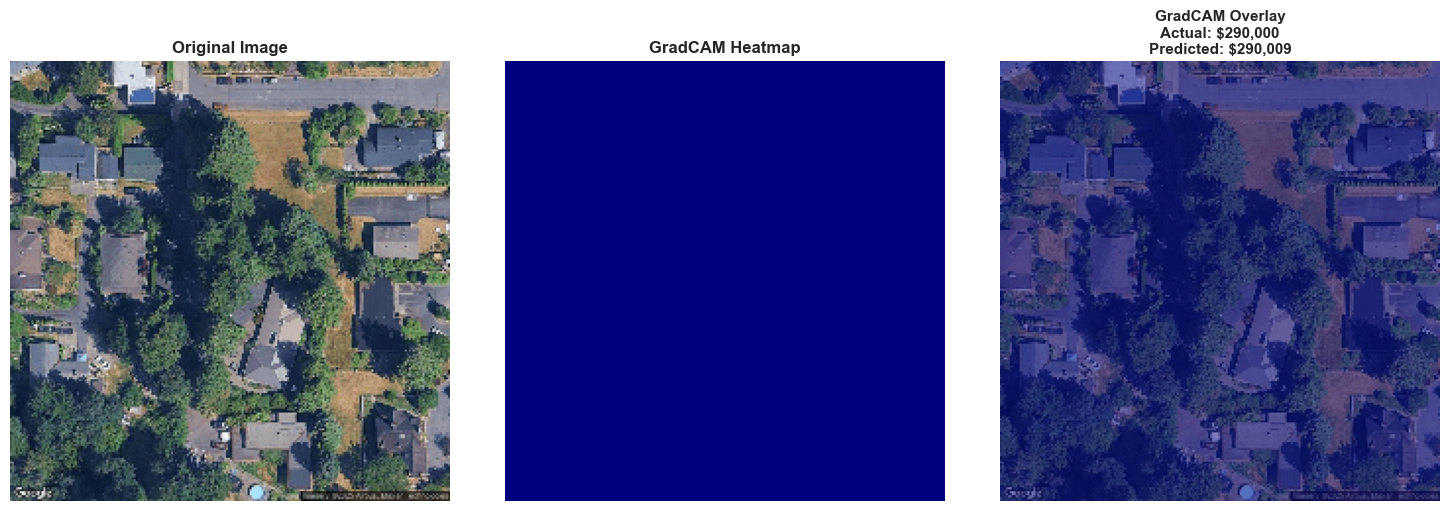

  Actual Price: $290,000
  Predicted Price: $290,009
  Error: $9


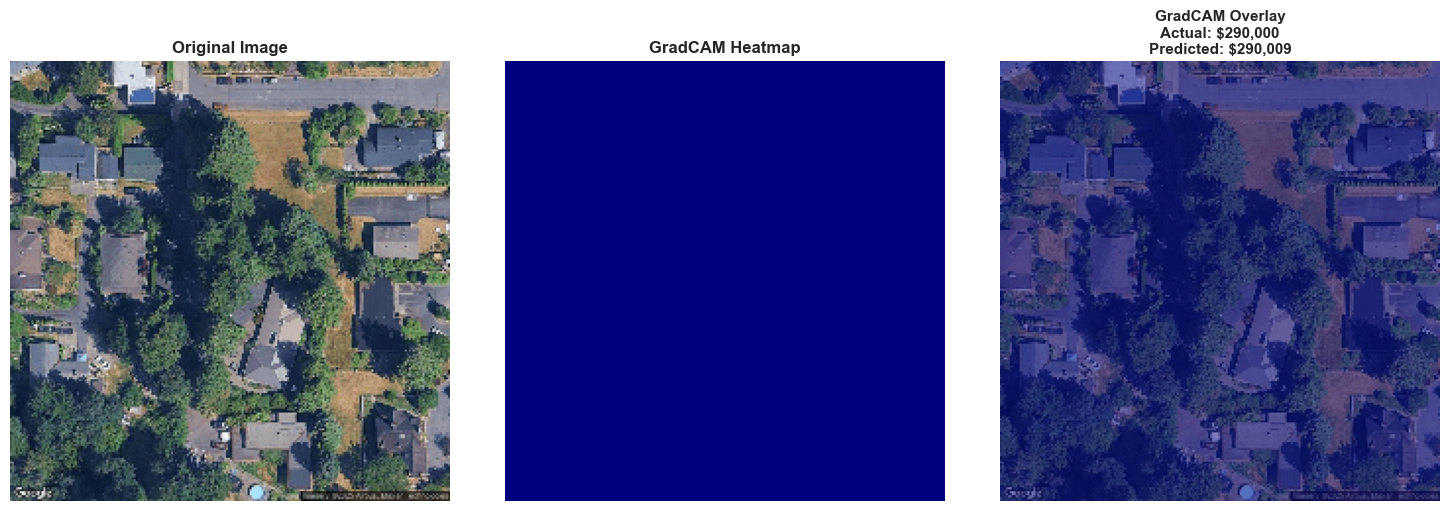


Median Prediction:
------------------------------------------------------------
  Actual Price: $329,950
  Predicted Price: $276,307
  Error: $53,643


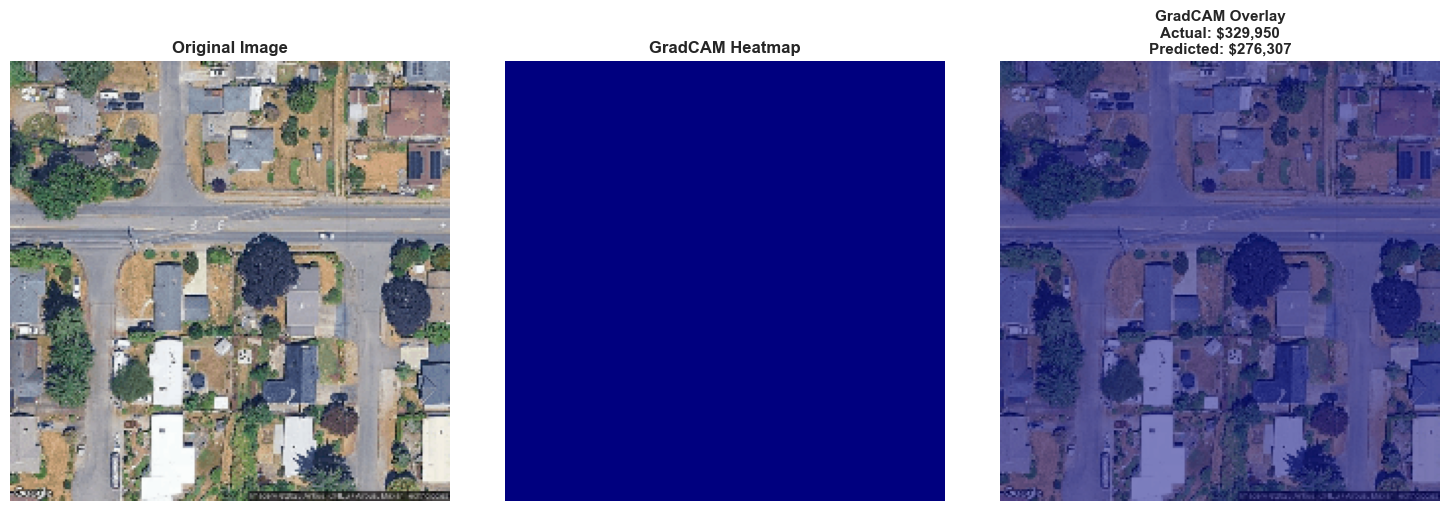

  Actual Price: $329,950
  Predicted Price: $276,307
  Error: $53,643


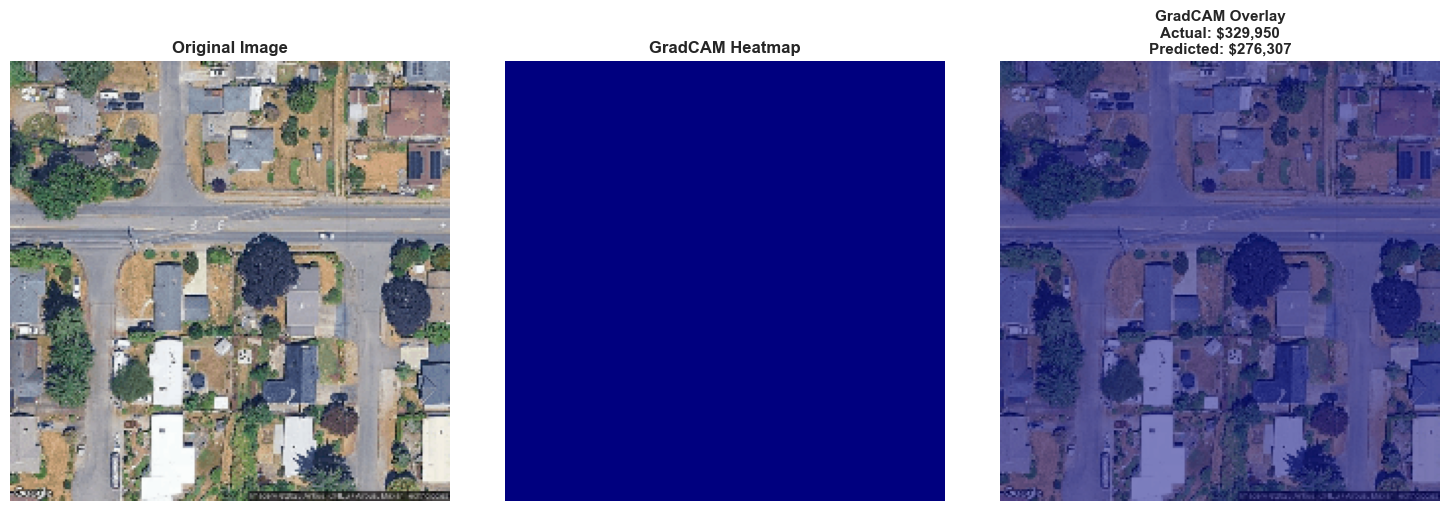


Worst Prediction:
------------------------------------------------------------
  Actual Price: $2,900,000
  Predicted Price: $1,487,029
  Error: $1,412,971


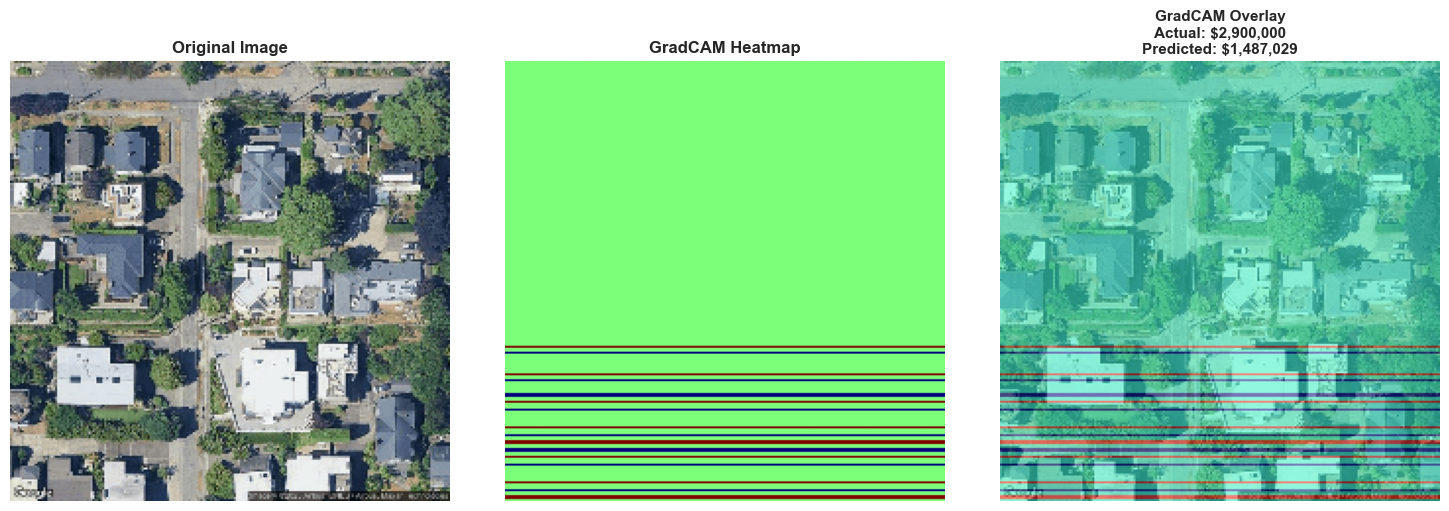

  Actual Price: $2,900,000
  Predicted Price: $1,487,029
  Error: $1,412,971


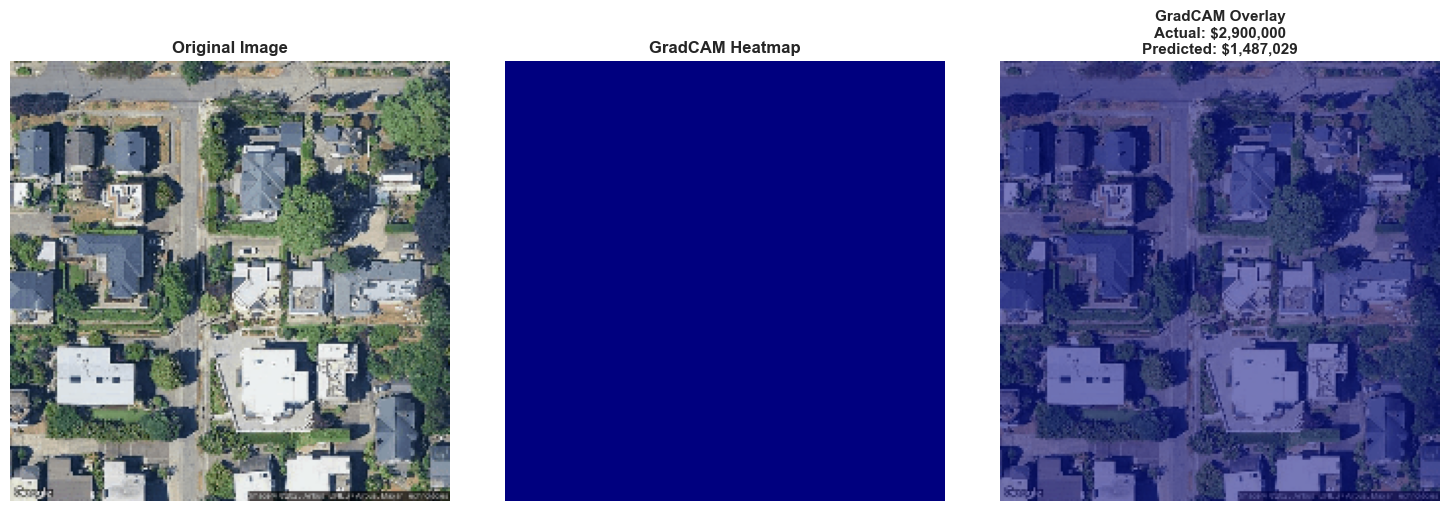

In [159]:
print("\n" + "=" * 80)
print("GRADCAM INTERPRETABILITY - ResNet50")
print("=" * 80)

# Get predictions from resnet50 model
trained_resnet50_model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for batch in val_dl_loader:
        images = batch['image'].to(DEVICE)
        tabular = batch['tabular'].to(DEVICE)
        targets = batch['target'].to(DEVICE)
        
        preds = trained_dl_model(images, tabular)
        all_preds.append(preds.cpu())
        all_targets.append(targets.cpu())

all_preds = torch.cat(all_preds).numpy().flatten()
all_targets = torch.cat(all_targets).numpy().flatten()

# Denormalize and convert from log scale
preds_denorm = all_preds * target_std + target_mean
targets_denorm = all_targets * target_std + target_mean
val_predictions = np.expm1(preds_denorm)
val_targets = np.expm1(targets_denorm)

# Select sample predictions
prediction_errors = np.abs(val_targets - val_predictions)

best_prediction_idx = np.argmin(prediction_errors)
worst_prediction_idx = np.argmax(prediction_errors)
median_prediction_idx = np.argsort(prediction_errors)[len(prediction_errors) // 2]

sample_indices = [best_prediction_idx, median_prediction_idx, worst_prediction_idx]
sample_labels = ['Best Prediction', 'Median Prediction', 'Worst Prediction']

for idx, label in zip(sample_indices, sample_labels):
    print(f"\n{label}:")
    print("-" * 60)
    
    sample_row = validation_data.iloc[idx]
    image_path = os.path.join(cfg.IMAGE_DIRECTORY, str(sample_row['image_path']))
    tabular_feats = sample_row[feature_columns].values.astype(np.float32)
    
    actual = val_targets[idx]
    predicted = val_predictions[idx]
    
    print(f"  Actual Price: ${actual:,.0f}")
    print(f"  Predicted Price: ${predicted:,.0f}")
    print(f"  Error: ${np.abs(actual - predicted):,.0f}")
    
    if os.path.exists(image_path):
        generate_gradcam_visualization(
            trained_resnet50_model, image_path, tabular_feats,
            actual, predicted, IMAGE_MEAN, IMAGE_STD
        )
    
    print(f"  Actual Price: ${actual:,.0f}")
    print(f"  Predicted Price: ${predicted:,.0f}")
    print(f"  Error: ${np.abs(actual - predicted):,.0f}")
    
    if os.path.exists(image_path):
        generate_gradcam_visualization(
            trained_dl_model, image_path, tabular_feats,
            actual, predicted, IMAGE_MEAN, IMAGE_STD
        )

## 14. SHAP Interpretability

In [147]:
import shap

In [148]:
def compute_shap_for_tabular_model(model, X_train, X_val, feature_names, n_samples=100):
    """Compute SHAP values for tabular features"""
    
    print("\nComputing SHAP values...")
    
    # Use subset for efficiency
    background_data = shap.sample(X_train, min(n_samples, len(X_train)))
    
    explainer = shap.TreeExplainer(model)
    
    shap_values = explainer.shap_values(X_val[:min(n_samples, len(X_val))])
    
    return explainer, shap_values, X_val[:min(n_samples, len(X_val))]


SHAP Analysis for XGBoost

Computing SHAP values...

SHAP Summary Plot:


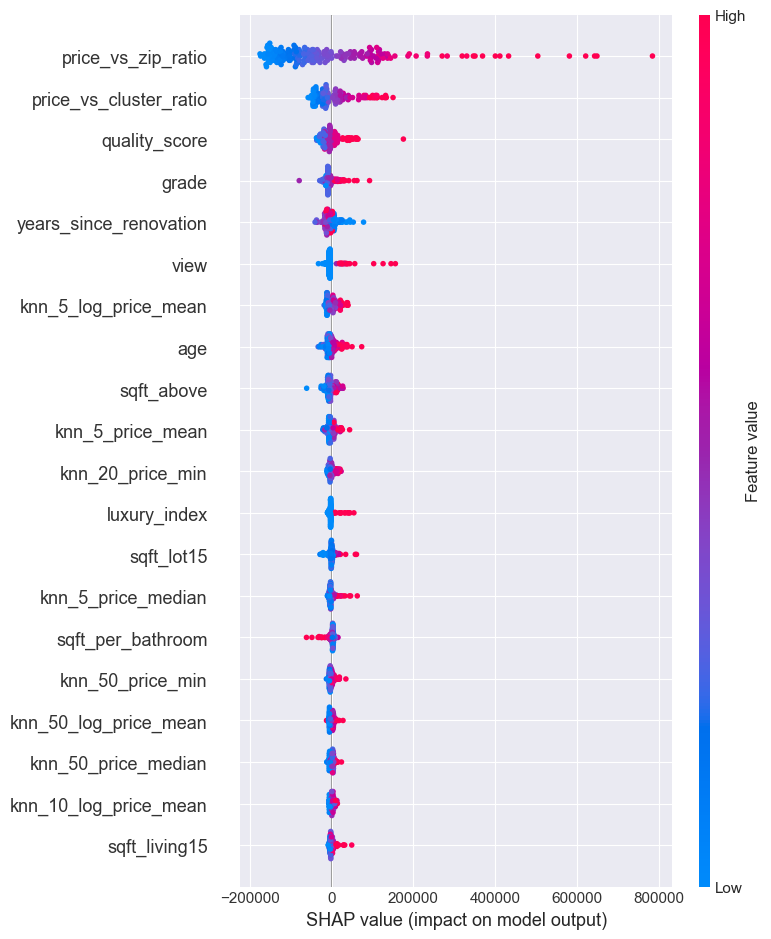


SHAP Feature Importance:


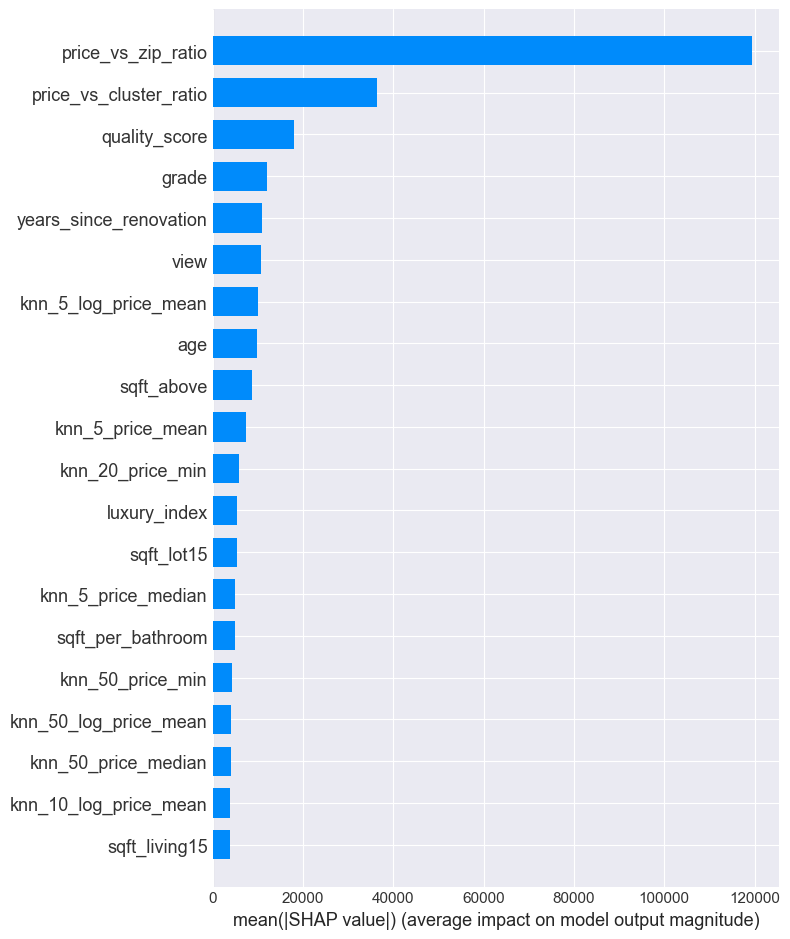

In [149]:
# SHAP for best tabular model
best_tabular_model_name = ml_comparison_df[ml_comparison_df['Category'] == 'Tabular'].iloc[0]['Model']
best_tabular_model = tabular_model_results[best_tabular_model_name]['model']

print(f"\nSHAP Analysis for {best_tabular_model_name}")
print("=" * 60)

try:
    shap_explainer, shap_vals, shap_data = compute_shap_for_tabular_model(
        best_tabular_model, X_train_tabular, X_val_tabular, feature_columns, n_samples=200
    )
    
    # Summary plot
    print("\nSHAP Summary Plot:")
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_vals, shap_data, feature_names=feature_columns, show=False)
    plt.tight_layout()
    plt.show()
    
    # Bar plot
    print("\nSHAP Feature Importance:")
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_vals, shap_data, feature_names=feature_columns, plot_type='bar', show=False)
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"SHAP analysis failed: {e}")

In [150]:
# SHAP for multimodal tabular features
def compute_shap_for_multimodal_tabular(model, data_loader, feature_names, n_samples=100):
    """Compute SHAP values for tabular branch of multimodal model"""
    
    model.eval()
    
    # Collect tabular inputs and outputs
    tabular_inputs = []
    
    for batch in data_loader:
        tabular = batch['tabular'].numpy()
        tabular_inputs.extend(tabular)
        if len(tabular_inputs) >= n_samples:
            break
    
    tabular_inputs = np.array(tabular_inputs[:n_samples])
    
    # Create wrapper for tabular branch
    class TabularBranchWrapper:
        def __init__(self, model, mean_image_features):
            self.model = model
            self.mean_image_features = mean_image_features
        
        def predict(self, X):
            self.model.eval()
            with torch.no_grad():
                X_tensor = torch.tensor(X, dtype=torch.float32).to(DEVICE)
                batch_size = X_tensor.shape[0]
                
                # Use mean image features
                img_features = self.mean_image_features.repeat(batch_size, 1)
                tab_features = self.model.tabular_branch(X_tensor)
                combined = torch.cat([img_features, tab_features], dim=1)
                output = self.model.fusion_layers(combined)
                
                return output.cpu().numpy().flatten()
    
    # Compute mean image features from training data
    with torch.no_grad():
        sample_features = []
        for batch in train_dl_loader:
            images = batch['image'].to(DEVICE)
            img_feats = model.image_backbone(images)
            img_feats = torch.flatten(img_feats, 1)
            img_feats = model.image_head(img_feats)
            sample_features.extend(img_feats.cpu().numpy())
            if len(sample_features) >= 100:
                break
        mean_img_features = torch.tensor(np.mean(sample_features[:100], axis=0), 
                                         dtype=torch.float32).unsqueeze(0).to(DEVICE)
    
    wrapper = TabularBranchWrapper(model, mean_img_features)
    
    explainer = shap.KernelExplainer(wrapper.predict, tabular_inputs[:50])
    shap_values = explainer.shap_values(tabular_inputs[:min(50, len(tabular_inputs))])
    
    return shap_values, tabular_inputs[:min(50, len(tabular_inputs))]


SHAP Analysis for Deep Learning Model (Tabular Features)


  0%|          | 0/50 [00:00<?, ?it/s]


SHAP Summary Plot (DL Model - Tabular Features):


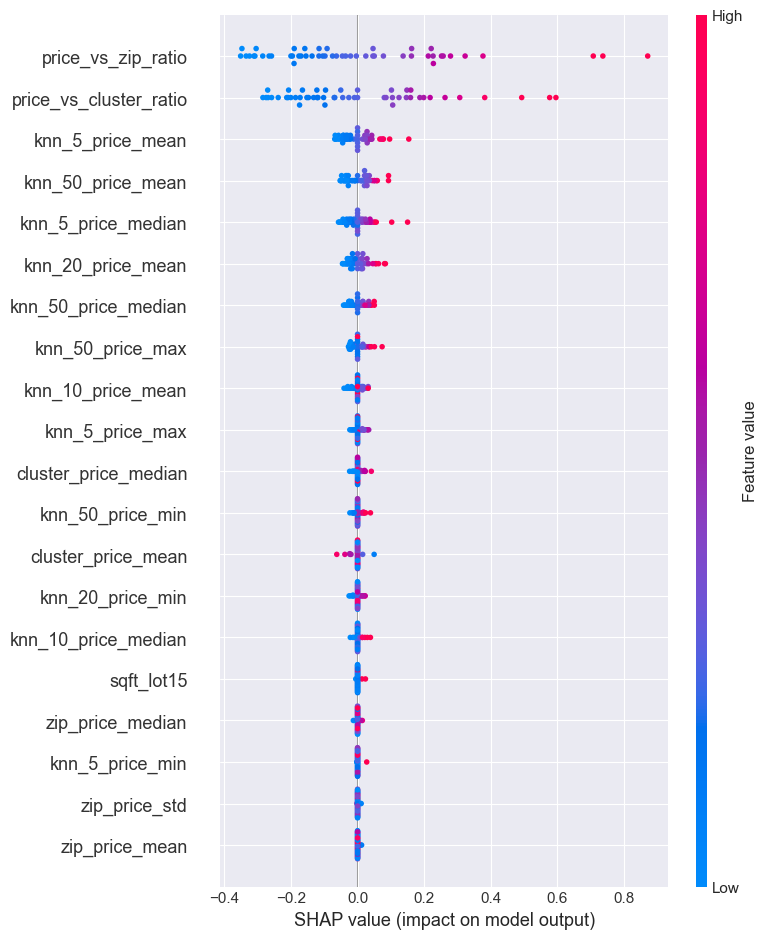

In [152]:
print("\nSHAP Analysis for Deep Learning Model (Tabular Features)")
print("=" * 60)

try:
    dl_shap_values, dl_shap_data = compute_shap_for_multimodal_tabular(
        trained_dl_model, val_dl_loader, feature_columns, n_samples=100
    )
    
    print("\nSHAP Summary Plot (DL Model - Tabular Features):")
    plt.figure(figsize=(12, 8))
    shap.summary_plot(dl_shap_values, dl_shap_data, feature_names=feature_columns, show=False)
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"SHAP analysis for DL model failed: {e}")

# 15. Predictions

In [172]:
# Create a test version of the dataset - uses full paths directly
class TestMultimodalDataset(Dataset):
    """Dataset for test data - no targets"""
    
    def __init__(self, dataframe, tabular_cols, image_col='image_path', transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.tabular_cols = tabular_cols
        self.image_col = image_col
        self.transform = transform
        
        self.valid_indices = []
        for idx in range(len(self.dataframe)):
            img_path = self.dataframe.loc[idx, self.image_col]  # Already full path
            if os.path.exists(img_path):
                self.valid_indices.append(idx)
        
        print(f"Dataset: {len(self.valid_indices)}/{len(self.dataframe)} valid samples")
    
    def __len__(self):
        return len(self.valid_indices)
    
    def __getitem__(self, idx):
        actual_idx = self.valid_indices[idx]
        
        img_path = self.dataframe.loc[actual_idx, self.image_col]  # Use full path directly
        
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        
        tabular_features = self.dataframe.loc[actual_idx, self.tabular_cols].values.astype(np.float32)
        tabular_tensor = torch.tensor(tabular_features, dtype=torch.float32)
        
        return {
            'id': self.dataframe.loc[actual_idx, 'id'],
            'image': image,
            'tabular': tabular_tensor
        }

# Load test data
test_df = pd.read_csv('../data/processed/test.csv')
print(f"Test samples loaded: {len(test_df)}")

tabular_feature_names = feature_columns 

test_dataset = TestMultimodalDataset(
    dataframe=test_df,
    tabular_cols=tabular_feature_names,
    image_col='image_path',
    transform=dl_transform
)

test_loader = DataLoader(
    test_dataset,
    batch_size=cfg.BATCH_SIZE,
    shuffle=False,
    num_workers=cfg.NUM_WORKERS
)

# Generate predictions
all_ids = []
all_preds = []

print("Generating predictions...")
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Predicting"):
        ids = batch['id'].numpy()
        images = batch['image'].to(DEVICE)
        tabular = batch['tabular'].to(DEVICE)
        
        # Use ensemble.predict()
        preds = weighted_ensemble.predict(images, tabular)
        
        all_ids.extend(ids)
        all_preds.append(preds.cpu())

# Concatenate predictions
all_preds = torch.cat(all_preds).numpy().flatten()

# Denormalize predictions
preds_denorm = all_preds * target_std + target_mean

# Convert from log scale to original price
preds_original = np.expm1(preds_denorm)

# Create DataFrame
predictions_df = pd.DataFrame({
    'id': all_ids,
    'price': preds_original
})

Test samples loaded: 5404
Dataset: 5404/5404 valid samples
Generating predictions...


Predicting: 100%|██████████| 169/169 [02:20<00:00,  1.20it/s]


In [173]:
# Sort by id and save
predictions_df = predictions_df.sort_values('id').reset_index(drop=True)
predictions_df.to_csv('../predictions.csv', index=False)

print(f"\n✓ Predictions saved to ../predictions.csv")
print(f"\nPrediction Summary:")
print(predictions_df['price'].describe())


✓ Predictions saved to ../predictions.csv

Prediction Summary:
count    5.404000e+03
mean     5.366381e+05
std      4.165671e+05
min      1.981391e+05
25%      3.386343e+05
50%      4.592505e+05
75%      6.315737e+05
max      1.669896e+07
Name: price, dtype: float64
